In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0,
    'binarize'      : True,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_0


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4356408, 828)
(4356408, 7)
validation
(600264, 828)
(600264, 7)
test
(573544, 828)
(573544, 7)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 7)                 903       


Total params: 1538823 (5.87 MB)


Trainable params: 1538823 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/436 [..............................] - ETA: 9:01 - loss: 2.3684 - STD: 0.1565 - MAE: 0.2439

  5/436 [..............................] - ETA: 7s - loss: 2.0576 - STD: 0.0863 - MAE: 0.2414  

  9/436 [..............................] - ETA: 7s - loss: 2.0168 - STD: 0.0689 - MAE: 0.2420

 13/436 [..............................] - ETA: 6s - loss: 1.9939 - STD: 0.0613 - MAE: 0.2422

 17/436 [>.............................] - ETA: 6s - loss: 1.9758 - STD: 0.0572 - MAE: 0.2420

 21/436 [>.............................] - ETA: 6s - loss: 1.9656 - STD: 0.0549 - MAE: 0.2420

 25/436 [>.............................] - ETA: 6s - loss: 1.9585 - STD: 0.0534 - MAE: 0.2419

 29/436 [>.............................] - ETA: 6s - loss: 1.9518 - STD: 0.0516 - MAE: 0.2418

 33/436 [=>............................] - ETA: 6s - loss: 1.9466 - STD: 0.0499 - MAE: 0.2418

 37/436 [=>............................] - ETA: 6s - loss: 1.9422 - STD: 0.0485 - MAE: 0.2418

 41/436 [=>............................] - ETA: 6s - loss: 1.9373 - STD: 0.0474 - MAE: 0.2417

 45/436 [==>...........................] - ETA: 6s - loss: 1.9317 - STD: 0.0470 - MAE: 0.2415

 49/436 [==>...........................] - ETA: 6s - loss: 1.9250 - STD: 0.0468 - MAE: 0.2412

 53/436 [==>...........................] - ETA: 6s - loss: 1.9172 - STD: 0.0475 - MAE: 0.2408

 57/436 [==>...........................] - ETA: 5s - loss: 1.9086 - STD: 0.0490 - MAE: 0.2403

 61/436 [===>..........................] - ETA: 5s - loss: 1.8991 - STD: 0.0507 - MAE: 0.2396

 65/436 [===>..........................] - ETA: 5s - loss: 1.8898 - STD: 0.0527 - MAE: 0.2390

 69/436 [===>..........................] - ETA: 5s - loss: 1.8803 - STD: 0.0546 - MAE: 0.2383

 73/436 [====>.........................] - ETA: 5s - loss: 1.8704 - STD: 0.0566 - MAE: 0.2376

 77/436 [====>.........................] - ETA: 5s - loss: 1.8605 - STD: 0.0586 - MAE: 0.2368

 81/436 [====>.........................] - ETA: 5s - loss: 1.8506 - STD: 0.0606 - MAE: 0.2361

 84/436 [====>.........................] - ETA: 5s - loss: 1.8428 - STD: 0.0621 - MAE: 0.2355

 88/436 [=====>........................] - ETA: 5s - loss: 1.8322 - STD: 0.0641 - MAE: 0.2347

 92/436 [=====>........................] - ETA: 5s - loss: 1.8207 - STD: 0.0661 - MAE: 0.2338

 96/436 [=====>........................] - ETA: 5s - loss: 1.8085 - STD: 0.0682 - MAE: 0.2329

100/436 [=====>........................] - ETA: 5s - loss: 1.7955 - STD: 0.0705 - MAE: 0.2319

104/436 [======>.......................] - ETA: 5s - loss: 1.7821 - STD: 0.0730 - MAE: 0.2308

108/436 [======>.......................] - ETA: 5s - loss: 1.7691 - STD: 0.0756 - MAE: 0.2296

112/436 [======>.......................] - ETA: 5s - loss: 1.7564 - STD: 0.0782 - MAE: 0.2285

116/436 [======>.......................] - ETA: 5s - loss: 1.7441 - STD: 0.0807 - MAE: 0.2274

120/436 [=======>......................] - ETA: 4s - loss: 1.7326 - STD: 0.0831 - MAE: 0.2264

124/436 [=======>......................] - ETA: 4s - loss: 1.7214 - STD: 0.0854 - MAE: 0.2254

128/436 [=======>......................] - ETA: 4s - loss: 1.7106 - STD: 0.0876 - MAE: 0.2244

132/436 [========>.....................] - ETA: 4s - loss: 1.7005 - STD: 0.0897 - MAE: 0.2235

135/436 [========>.....................] - ETA: 4s - loss: 1.6934 - STD: 0.0911 - MAE: 0.2229

139/436 [========>.....................] - ETA: 4s - loss: 1.6838 - STD: 0.0930 - MAE: 0.2220

143/436 [========>.....................] - ETA: 4s - loss: 1.6745 - STD: 0.0948 - MAE: 0.2212

147/436 [=========>....................] - ETA: 4s - loss: 1.6657 - STD: 0.0966 - MAE: 0.2204

151/436 [=========>....................] - ETA: 4s - loss: 1.6569 - STD: 0.0983 - MAE: 0.2196

155/436 [=========>....................] - ETA: 4s - loss: 1.6485 - STD: 0.0999 - MAE: 0.2188

159/436 [=========>....................] - ETA: 4s - loss: 1.6407 - STD: 0.1015 - MAE: 0.2181

163/436 [==========>...................] - ETA: 4s - loss: 1.6329 - STD: 0.1030 - MAE: 0.2174

167/436 [==========>...................] - ETA: 4s - loss: 1.6254 - STD: 0.1045 - MAE: 0.2167

171/436 [==========>...................] - ETA: 4s - loss: 1.6181 - STD: 0.1059 - MAE: 0.2160

175/436 [===========>..................] - ETA: 4s - loss: 1.6112 - STD: 0.1072 - MAE: 0.2154

179/436 [===========>..................] - ETA: 4s - loss: 1.6043 - STD: 0.1086 - MAE: 0.2147

183/436 [===========>..................] - ETA: 3s - loss: 1.5977 - STD: 0.1099 - MAE: 0.2141

187/436 [===========>..................] - ETA: 3s - loss: 1.5913 - STD: 0.1111 - MAE: 0.2135

191/436 [============>.................] - ETA: 3s - loss: 1.5850 - STD: 0.1123 - MAE: 0.2129

195/436 [============>.................] - ETA: 3s - loss: 1.5789 - STD: 0.1135 - MAE: 0.2124

199/436 [============>.................] - ETA: 3s - loss: 1.5728 - STD: 0.1147 - MAE: 0.2118

203/436 [============>.................] - ETA: 3s - loss: 1.5670 - STD: 0.1158 - MAE: 0.2112

207/436 [=============>................] - ETA: 3s - loss: 1.5613 - STD: 0.1169 - MAE: 0.2107

211/436 [=============>................] - ETA: 3s - loss: 1.5557 - STD: 0.1179 - MAE: 0.2102

215/436 [=============>................] - ETA: 3s - loss: 1.5502 - STD: 0.1190 - MAE: 0.2096

219/436 [==============>...............] - ETA: 3s - loss: 1.5450 - STD: 0.1200 - MAE: 0.2091

223/436 [==============>...............] - ETA: 3s - loss: 1.5398 - STD: 0.1210 - MAE: 0.2086

227/436 [==============>...............] - ETA: 3s - loss: 1.5349 - STD: 0.1220 - MAE: 0.2082

231/436 [==============>...............] - ETA: 3s - loss: 1.5299 - STD: 0.1229 - MAE: 0.2077

235/436 [===============>..............] - ETA: 3s - loss: 1.5251 - STD: 0.1239 - MAE: 0.2072

239/436 [===============>..............] - ETA: 3s - loss: 1.5203 - STD: 0.1248 - MAE: 0.2067

243/436 [===============>..............] - ETA: 3s - loss: 1.5157 - STD: 0.1257 - MAE: 0.2063

247/436 [===============>..............] - ETA: 2s - loss: 1.5112 - STD: 0.1265 - MAE: 0.2059

251/436 [================>.............] - ETA: 2s - loss: 1.5069 - STD: 0.1273 - MAE: 0.2054

255/436 [================>.............] - ETA: 2s - loss: 1.5026 - STD: 0.1282 - MAE: 0.2050

259/436 [================>.............] - ETA: 2s - loss: 1.4986 - STD: 0.1290 - MAE: 0.2046

263/436 [=================>............] - ETA: 2s - loss: 1.4944 - STD: 0.1297 - MAE: 0.2042

267/436 [=================>............] - ETA: 2s - loss: 1.4902 - STD: 0.1305 - MAE: 0.2038

271/436 [=================>............] - ETA: 2s - loss: 1.4861 - STD: 0.1312 - MAE: 0.2034

274/436 [=================>............] - ETA: 2s - loss: 1.4834 - STD: 0.1317 - MAE: 0.2031

278/436 [==================>...........] - ETA: 2s - loss: 1.4797 - STD: 0.1325 - MAE: 0.2028

282/436 [==================>...........] - ETA: 2s - loss: 1.4762 - STD: 0.1332 - MAE: 0.2024

286/436 [==================>...........] - ETA: 2s - loss: 1.4727 - STD: 0.1339 - MAE: 0.2021

290/436 [==================>...........] - ETA: 2s - loss: 1.4689 - STD: 0.1345 - MAE: 0.2017

294/436 [===================>..........] - ETA: 2s - loss: 1.4654 - STD: 0.1352 - MAE: 0.2014

298/436 [===================>..........] - ETA: 2s - loss: 1.4618 - STD: 0.1358 - MAE: 0.2010

302/436 [===================>..........] - ETA: 2s - loss: 1.4583 - STD: 0.1365 - MAE: 0.2007

306/436 [====================>.........] - ETA: 2s - loss: 1.4549 - STD: 0.1371 - MAE: 0.2004

310/436 [====================>.........] - ETA: 2s - loss: 1.4515 - STD: 0.1377 - MAE: 0.2000

314/436 [====================>.........] - ETA: 2s - loss: 1.4481 - STD: 0.1383 - MAE: 0.1997

318/436 [====================>.........] - ETA: 2s - loss: 1.4447 - STD: 0.1389 - MAE: 0.1994

322/436 [=====================>........] - ETA: 1s - loss: 1.4415 - STD: 0.1394 - MAE: 0.1991

326/436 [=====================>........] - ETA: 1s - loss: 1.4383 - STD: 0.1400 - MAE: 0.1988

330/436 [=====================>........] - ETA: 1s - loss: 1.4351 - STD: 0.1406 - MAE: 0.1985

334/436 [=====================>........] - ETA: 1s - loss: 1.4322 - STD: 0.1411 - MAE: 0.1982

338/436 [======================>.......] - ETA: 1s - loss: 1.4291 - STD: 0.1417 - MAE: 0.1979

342/436 [======================>.......] - ETA: 1s - loss: 1.4262 - STD: 0.1422 - MAE: 0.1976

346/436 [======================>.......] - ETA: 1s - loss: 1.4231 - STD: 0.1427 - MAE: 0.1973

350/436 [=======================>......] - ETA: 1s - loss: 1.4202 - STD: 0.1432 - MAE: 0.1970

354/436 [=======================>......] - ETA: 1s - loss: 1.4173 - STD: 0.1437 - MAE: 0.1967

358/436 [=======================>......] - ETA: 1s - loss: 1.4145 - STD: 0.1442 - MAE: 0.1964

362/436 [=======================>......] - ETA: 1s - loss: 1.4116 - STD: 0.1447 - MAE: 0.1962

366/436 [========================>.....] - ETA: 1s - loss: 1.4091 - STD: 0.1452 - MAE: 0.1959

370/436 [========================>.....] - ETA: 1s - loss: 1.4065 - STD: 0.1457 - MAE: 0.1956

374/436 [========================>.....] - ETA: 1s - loss: 1.4039 - STD: 0.1462 - MAE: 0.1954

378/436 [=========================>....] - ETA: 0s - loss: 1.4012 - STD: 0.1466 - MAE: 0.1951

382/436 [=========================>....] - ETA: 0s - loss: 1.3985 - STD: 0.1471 - MAE: 0.1949

386/436 [=========================>....] - ETA: 0s - loss: 1.3959 - STD: 0.1476 - MAE: 0.1946

390/436 [=========================>....] - ETA: 0s - loss: 1.3934 - STD: 0.1480 - MAE: 0.1944

394/436 [==========================>...] - ETA: 0s - loss: 1.3909 - STD: 0.1484 - MAE: 0.1941

397/436 [==========================>...] - ETA: 0s - loss: 1.3891 - STD: 0.1487 - MAE: 0.1939

401/436 [==========================>...] - ETA: 0s - loss: 1.3865 - STD: 0.1492 - MAE: 0.1937

405/436 [==========================>...] - ETA: 0s - loss: 1.3841 - STD: 0.1496 - MAE: 0.1934

409/436 [===========================>..] - ETA: 0s - loss: 1.3817 - STD: 0.1500 - MAE: 0.1932

413/436 [===========================>..] - ETA: 0s - loss: 1.3793 - STD: 0.1504 - MAE: 0.1930

417/436 [===========================>..] - ETA: 0s - loss: 1.3772 - STD: 0.1508 - MAE: 0.1927

421/436 [===========================>..] - ETA: 0s - loss: 1.3750 - STD: 0.1512 - MAE: 0.1925

425/436 [============================>.] - ETA: 0s - loss: 1.3727 - STD: 0.1516 - MAE: 0.1923

429/436 [============================>.] - ETA: 0s - loss: 1.3706 - STD: 0.1520 - MAE: 0.1921

433/436 [============================>.] - ETA: 0s - loss: 1.3684 - STD: 0.1524 - MAE: 0.1919

436/436 [==============================] - 10s 20ms/step - loss: 1.3668 - STD: 0.1527 - MAE: 0.1917 - val_loss: 1.1611 - val_STD: 0.1836 - val_MAE: 0.1729


Epoch 2/10000


  1/436 [..............................] - ETA: 18s - loss: 1.1178 - STD: 0.1932 - MAE: 0.1677

  4/436 [..............................] - ETA: 7s - loss: 1.1361 - STD: 0.1932 - MAE: 0.1686 

  8/436 [..............................] - ETA: 6s - loss: 1.1317 - STD: 0.1934 - MAE: 0.1682

 12/436 [..............................] - ETA: 6s - loss: 1.1290 - STD: 0.1938 - MAE: 0.1679

 16/436 [>.............................] - ETA: 6s - loss: 1.1257 - STD: 0.1939 - MAE: 0.1677

 20/436 [>.............................] - ETA: 6s - loss: 1.1236 - STD: 0.1940 - MAE: 0.1676

 24/436 [>.............................] - ETA: 6s - loss: 1.1208 - STD: 0.1942 - MAE: 0.1674

 28/436 [>.............................] - ETA: 6s - loss: 1.1195 - STD: 0.1945 - MAE: 0.1672

 32/436 [=>............................] - ETA: 6s - loss: 1.1193 - STD: 0.1946 - MAE: 0.1671

 36/436 [=>............................] - ETA: 6s - loss: 1.1180 - STD: 0.1947 - MAE: 0.1670

 40/436 [=>............................] - ETA: 6s - loss: 1.1171 - STD: 0.1948 - MAE: 0.1670

 44/436 [==>...........................] - ETA: 6s - loss: 1.1158 - STD: 0.1951 - MAE: 0.1668

 48/436 [==>...........................] - ETA: 5s - loss: 1.1157 - STD: 0.1953 - MAE: 0.1667

 52/436 [==>...........................] - ETA: 5s - loss: 1.1153 - STD: 0.1954 - MAE: 0.1666

 56/436 [==>...........................] - ETA: 5s - loss: 1.1154 - STD: 0.1956 - MAE: 0.1666

 60/436 [===>..........................] - ETA: 5s - loss: 1.1143 - STD: 0.1958 - MAE: 0.1664

 64/436 [===>..........................] - ETA: 5s - loss: 1.1133 - STD: 0.1959 - MAE: 0.1663

 68/436 [===>..........................] - ETA: 5s - loss: 1.1124 - STD: 0.1960 - MAE: 0.1662

 72/436 [===>..........................] - ETA: 5s - loss: 1.1114 - STD: 0.1962 - MAE: 0.1661

 76/436 [====>.........................] - ETA: 5s - loss: 1.1113 - STD: 0.1963 - MAE: 0.1661

 80/436 [====>.........................] - ETA: 5s - loss: 1.1106 - STD: 0.1965 - MAE: 0.1660

 84/436 [====>.........................] - ETA: 5s - loss: 1.1099 - STD: 0.1966 - MAE: 0.1659

 88/436 [=====>........................] - ETA: 5s - loss: 1.1093 - STD: 0.1968 - MAE: 0.1658

 92/436 [=====>........................] - ETA: 5s - loss: 1.1083 - STD: 0.1969 - MAE: 0.1657

 96/436 [=====>........................] - ETA: 5s - loss: 1.1074 - STD: 0.1970 - MAE: 0.1656

100/436 [=====>........................] - ETA: 5s - loss: 1.1063 - STD: 0.1971 - MAE: 0.1655

104/436 [======>.......................] - ETA: 5s - loss: 1.1054 - STD: 0.1972 - MAE: 0.1654

108/436 [======>.......................] - ETA: 5s - loss: 1.1051 - STD: 0.1973 - MAE: 0.1653

112/436 [======>.......................] - ETA: 4s - loss: 1.1056 - STD: 0.1974 - MAE: 0.1653

116/436 [======>.......................] - ETA: 4s - loss: 1.1050 - STD: 0.1976 - MAE: 0.1652

120/436 [=======>......................] - ETA: 4s - loss: 1.1041 - STD: 0.1977 - MAE: 0.1651

124/436 [=======>......................] - ETA: 4s - loss: 1.1033 - STD: 0.1978 - MAE: 0.1650

128/436 [=======>......................] - ETA: 4s - loss: 1.1023 - STD: 0.1979 - MAE: 0.1649

132/436 [========>.....................] - ETA: 4s - loss: 1.1013 - STD: 0.1980 - MAE: 0.1648

136/436 [========>.....................] - ETA: 4s - loss: 1.1004 - STD: 0.1981 - MAE: 0.1647

140/436 [========>.....................] - ETA: 4s - loss: 1.0997 - STD: 0.1983 - MAE: 0.1646

144/436 [========>.....................] - ETA: 4s - loss: 1.0991 - STD: 0.1984 - MAE: 0.1646

148/436 [=========>....................] - ETA: 4s - loss: 1.0985 - STD: 0.1985 - MAE: 0.1645

152/436 [=========>....................] - ETA: 4s - loss: 1.0977 - STD: 0.1986 - MAE: 0.1644

156/436 [=========>....................] - ETA: 4s - loss: 1.0970 - STD: 0.1987 - MAE: 0.1643

160/436 [==========>...................] - ETA: 4s - loss: 1.0964 - STD: 0.1988 - MAE: 0.1642

164/436 [==========>...................] - ETA: 4s - loss: 1.0961 - STD: 0.1989 - MAE: 0.1642

168/436 [==========>...................] - ETA: 4s - loss: 1.0977 - STD: 0.1990 - MAE: 0.1642

172/436 [==========>...................] - ETA: 4s - loss: 1.0981 - STD: 0.1991 - MAE: 0.1642

176/436 [===========>..................] - ETA: 3s - loss: 1.0976 - STD: 0.1992 - MAE: 0.1641

180/436 [===========>..................] - ETA: 3s - loss: 1.0974 - STD: 0.1993 - MAE: 0.1641

184/436 [===========>..................] - ETA: 3s - loss: 1.0967 - STD: 0.1994 - MAE: 0.1640

188/436 [===========>..................] - ETA: 3s - loss: 1.0960 - STD: 0.1995 - MAE: 0.1639

192/436 [============>.................] - ETA: 3s - loss: 1.0952 - STD: 0.1996 - MAE: 0.1638

196/436 [============>.................] - ETA: 3s - loss: 1.0944 - STD: 0.1997 - MAE: 0.1638

200/436 [============>.................] - ETA: 3s - loss: 1.0935 - STD: 0.1997 - MAE: 0.1637

204/436 [=============>................] - ETA: 3s - loss: 1.0928 - STD: 0.1998 - MAE: 0.1636

208/436 [=============>................] - ETA: 3s - loss: 1.0921 - STD: 0.1999 - MAE: 0.1635

212/436 [=============>................] - ETA: 3s - loss: 1.0915 - STD: 0.2000 - MAE: 0.1635

216/436 [=============>................] - ETA: 3s - loss: 1.0908 - STD: 0.2001 - MAE: 0.1634

220/436 [==============>...............] - ETA: 3s - loss: 1.0903 - STD: 0.2002 - MAE: 0.1633

224/436 [==============>...............] - ETA: 3s - loss: 1.0895 - STD: 0.2003 - MAE: 0.1632

228/436 [==============>...............] - ETA: 3s - loss: 1.0887 - STD: 0.2004 - MAE: 0.1631

232/436 [==============>...............] - ETA: 3s - loss: 1.0880 - STD: 0.2005 - MAE: 0.1630

236/436 [===============>..............] - ETA: 3s - loss: 1.0873 - STD: 0.2006 - MAE: 0.1630

240/436 [===============>..............] - ETA: 3s - loss: 1.0867 - STD: 0.2007 - MAE: 0.1629

244/436 [===============>..............] - ETA: 2s - loss: 1.0862 - STD: 0.2008 - MAE: 0.1628

248/436 [================>.............] - ETA: 2s - loss: 1.0858 - STD: 0.2009 - MAE: 0.1628

252/436 [================>.............] - ETA: 2s - loss: 1.0851 - STD: 0.2010 - MAE: 0.1627

256/436 [================>.............] - ETA: 2s - loss: 1.0846 - STD: 0.2011 - MAE: 0.1626

260/436 [================>.............] - ETA: 2s - loss: 1.0841 - STD: 0.2012 - MAE: 0.1626

264/436 [=================>............] - ETA: 2s - loss: 1.0836 - STD: 0.2013 - MAE: 0.1625

268/436 [=================>............] - ETA: 2s - loss: 1.0832 - STD: 0.2014 - MAE: 0.1624

272/436 [=================>............] - ETA: 2s - loss: 1.0826 - STD: 0.2014 - MAE: 0.1624

276/436 [=================>............] - ETA: 2s - loss: 1.0822 - STD: 0.2015 - MAE: 0.1623

280/436 [==================>...........] - ETA: 2s - loss: 1.0816 - STD: 0.2016 - MAE: 0.1622

284/436 [==================>...........] - ETA: 2s - loss: 1.0810 - STD: 0.2017 - MAE: 0.1622

288/436 [==================>...........] - ETA: 2s - loss: 1.0804 - STD: 0.2017 - MAE: 0.1621

292/436 [===================>..........] - ETA: 2s - loss: 1.0799 - STD: 0.2018 - MAE: 0.1620

296/436 [===================>..........] - ETA: 2s - loss: 1.0792 - STD: 0.2019 - MAE: 0.1620

300/436 [===================>..........] - ETA: 2s - loss: 1.0788 - STD: 0.2020 - MAE: 0.1619

304/436 [===================>..........] - ETA: 2s - loss: 1.0790 - STD: 0.2021 - MAE: 0.1619

308/436 [====================>.........] - ETA: 1s - loss: 1.0792 - STD: 0.2022 - MAE: 0.1618

312/436 [====================>.........] - ETA: 1s - loss: 1.0789 - STD: 0.2023 - MAE: 0.1618

316/436 [====================>.........] - ETA: 1s - loss: 1.0787 - STD: 0.2024 - MAE: 0.1617

320/436 [=====================>........] - ETA: 1s - loss: 1.0783 - STD: 0.2024 - MAE: 0.1617

324/436 [=====================>........] - ETA: 1s - loss: 1.0780 - STD: 0.2025 - MAE: 0.1617

328/436 [=====================>........] - ETA: 1s - loss: 1.0775 - STD: 0.2026 - MAE: 0.1616

332/436 [=====================>........] - ETA: 1s - loss: 1.0769 - STD: 0.2026 - MAE: 0.1615

336/436 [======================>.......] - ETA: 1s - loss: 1.0764 - STD: 0.2027 - MAE: 0.1615

340/436 [======================>.......] - ETA: 1s - loss: 1.0758 - STD: 0.2028 - MAE: 0.1614

344/436 [======================>.......] - ETA: 1s - loss: 1.0754 - STD: 0.2028 - MAE: 0.1614

348/436 [======================>.......] - ETA: 1s - loss: 1.0749 - STD: 0.2029 - MAE: 0.1613

352/436 [=======================>......] - ETA: 1s - loss: 1.0745 - STD: 0.2030 - MAE: 0.1613

356/436 [=======================>......] - ETA: 1s - loss: 1.0742 - STD: 0.2030 - MAE: 0.1612

360/436 [=======================>......] - ETA: 1s - loss: 1.0739 - STD: 0.2031 - MAE: 0.1612

364/436 [========================>.....] - ETA: 1s - loss: 1.0737 - STD: 0.2032 - MAE: 0.1611

368/436 [========================>.....] - ETA: 1s - loss: 1.0735 - STD: 0.2032 - MAE: 0.1611

372/436 [========================>.....] - ETA: 0s - loss: 1.0731 - STD: 0.2033 - MAE: 0.1610

376/436 [========================>.....] - ETA: 0s - loss: 1.0727 - STD: 0.2034 - MAE: 0.1610

380/436 [=========================>....] - ETA: 0s - loss: 1.0723 - STD: 0.2034 - MAE: 0.1609

384/436 [=========================>....] - ETA: 0s - loss: 1.0718 - STD: 0.2035 - MAE: 0.1609

388/436 [=========================>....] - ETA: 0s - loss: 1.0713 - STD: 0.2036 - MAE: 0.1608

392/436 [=========================>....] - ETA: 0s - loss: 1.0708 - STD: 0.2036 - MAE: 0.1608

396/436 [==========================>...] - ETA: 0s - loss: 1.0702 - STD: 0.2037 - MAE: 0.1607

400/436 [==========================>...] - ETA: 0s - loss: 1.0696 - STD: 0.2038 - MAE: 0.1606

404/436 [==========================>...] - ETA: 0s - loss: 1.0691 - STD: 0.2038 - MAE: 0.1606

408/436 [===========================>..] - ETA: 0s - loss: 1.0685 - STD: 0.2039 - MAE: 0.1605

412/436 [===========================>..] - ETA: 0s - loss: 1.0680 - STD: 0.2040 - MAE: 0.1604

416/436 [===========================>..] - ETA: 0s - loss: 1.0674 - STD: 0.2041 - MAE: 0.1604

420/436 [===========================>..] - ETA: 0s - loss: 1.0671 - STD: 0.2041 - MAE: 0.1603

424/436 [============================>.] - ETA: 0s - loss: 1.0666 - STD: 0.2042 - MAE: 0.1603

428/436 [============================>.] - ETA: 0s - loss: 1.0662 - STD: 0.2043 - MAE: 0.1602

432/436 [============================>.] - ETA: 0s - loss: 1.0659 - STD: 0.2043 - MAE: 0.1602

436/436 [==============================] - ETA: 0s - loss: 1.0655 - STD: 0.2044 - MAE: 0.1601

436/436 [==============================] - 8s 17ms/step - loss: 1.0655 - STD: 0.2044 - MAE: 0.1601 - val_loss: 1.1122 - val_STD: 0.2055 - val_MAE: 0.1626


Epoch 3/10000


  1/436 [..............................] - ETA: 20s - loss: 1.0133 - STD: 0.2103 - MAE: 0.1547

  5/436 [..............................] - ETA: 6s - loss: 1.0192 - STD: 0.2112 - MAE: 0.1546 

  9/436 [..............................] - ETA: 6s - loss: 1.0192 - STD: 0.2113 - MAE: 0.1545

 13/436 [..............................] - ETA: 6s - loss: 1.0181 - STD: 0.2112 - MAE: 0.1545

 17/436 [>.............................] - ETA: 6s - loss: 1.0176 - STD: 0.2113 - MAE: 0.1545

 21/436 [>.............................] - ETA: 6s - loss: 1.0209 - STD: 0.2116 - MAE: 0.1545

 25/436 [>.............................] - ETA: 6s - loss: 1.0231 - STD: 0.2116 - MAE: 0.1547

 29/436 [>.............................] - ETA: 6s - loss: 1.0225 - STD: 0.2118 - MAE: 0.1546

 33/436 [=>............................] - ETA: 6s - loss: 1.0220 - STD: 0.2118 - MAE: 0.1545

 37/436 [=>............................] - ETA: 6s - loss: 1.0203 - STD: 0.2119 - MAE: 0.1543

 41/436 [=>............................] - ETA: 6s - loss: 1.0193 - STD: 0.2119 - MAE: 0.1543

 45/436 [==>...........................] - ETA: 6s - loss: 1.0186 - STD: 0.2119 - MAE: 0.1543

 49/436 [==>...........................] - ETA: 5s - loss: 1.0174 - STD: 0.2121 - MAE: 0.1541

 53/436 [==>...........................] - ETA: 5s - loss: 1.0169 - STD: 0.2122 - MAE: 0.1540

 57/436 [==>...........................] - ETA: 5s - loss: 1.0166 - STD: 0.2122 - MAE: 0.1540

 61/436 [===>..........................] - ETA: 5s - loss: 1.0159 - STD: 0.2122 - MAE: 0.1539

 65/436 [===>..........................] - ETA: 5s - loss: 1.0157 - STD: 0.2123 - MAE: 0.1539

 69/436 [===>..........................] - ETA: 5s - loss: 1.0146 - STD: 0.2123 - MAE: 0.1538

 73/436 [====>.........................] - ETA: 5s - loss: 1.0138 - STD: 0.2124 - MAE: 0.1538

 77/436 [====>.........................] - ETA: 5s - loss: 1.0136 - STD: 0.2125 - MAE: 0.1537

 81/436 [====>.........................] - ETA: 5s - loss: 1.0130 - STD: 0.2126 - MAE: 0.1536

 85/436 [====>.........................] - ETA: 5s - loss: 1.0121 - STD: 0.2126 - MAE: 0.1535

 89/436 [=====>........................] - ETA: 5s - loss: 1.0119 - STD: 0.2127 - MAE: 0.1535

 93/436 [=====>........................] - ETA: 5s - loss: 1.0113 - STD: 0.2128 - MAE: 0.1534

 97/436 [=====>........................] - ETA: 5s - loss: 1.0110 - STD: 0.2128 - MAE: 0.1534

101/436 [=====>........................] - ETA: 5s - loss: 1.0109 - STD: 0.2128 - MAE: 0.1534

105/436 [======>.......................] - ETA: 5s - loss: 1.0114 - STD: 0.2129 - MAE: 0.1534

109/436 [======>.......................] - ETA: 5s - loss: 1.0113 - STD: 0.2129 - MAE: 0.1534

113/436 [======>.......................] - ETA: 4s - loss: 1.0109 - STD: 0.2130 - MAE: 0.1533

117/436 [=======>......................] - ETA: 4s - loss: 1.0103 - STD: 0.2130 - MAE: 0.1532

121/436 [=======>......................] - ETA: 4s - loss: 1.0101 - STD: 0.2131 - MAE: 0.1532

125/436 [=======>......................] - ETA: 4s - loss: 1.0096 - STD: 0.2131 - MAE: 0.1532

129/436 [=======>......................] - ETA: 4s - loss: 1.0091 - STD: 0.2131 - MAE: 0.1531

133/436 [========>.....................] - ETA: 4s - loss: 1.0087 - STD: 0.2132 - MAE: 0.1531

137/436 [========>.....................] - ETA: 4s - loss: 1.0081 - STD: 0.2133 - MAE: 0.1530

141/436 [========>.....................] - ETA: 4s - loss: 1.0075 - STD: 0.2133 - MAE: 0.1529

145/436 [========>.....................] - ETA: 4s - loss: 1.0072 - STD: 0.2134 - MAE: 0.1529

149/436 [=========>....................] - ETA: 4s - loss: 1.0066 - STD: 0.2135 - MAE: 0.1528

153/436 [=========>....................] - ETA: 4s - loss: 1.0062 - STD: 0.2135 - MAE: 0.1528

157/436 [=========>....................] - ETA: 4s - loss: 1.0059 - STD: 0.2136 - MAE: 0.1527

161/436 [==========>...................] - ETA: 4s - loss: 1.0057 - STD: 0.2136 - MAE: 0.1527

165/436 [==========>...................] - ETA: 4s - loss: 1.0054 - STD: 0.2137 - MAE: 0.1526

169/436 [==========>...................] - ETA: 4s - loss: 1.0047 - STD: 0.2137 - MAE: 0.1526

173/436 [==========>...................] - ETA: 4s - loss: 1.0046 - STD: 0.2138 - MAE: 0.1525

177/436 [===========>..................] - ETA: 4s - loss: 1.0046 - STD: 0.2139 - MAE: 0.1525

181/436 [===========>..................] - ETA: 3s - loss: 1.0043 - STD: 0.2139 - MAE: 0.1525

185/436 [===========>..................] - ETA: 3s - loss: 1.0040 - STD: 0.2140 - MAE: 0.1524

189/436 [============>.................] - ETA: 3s - loss: 1.0036 - STD: 0.2140 - MAE: 0.1524

193/436 [============>.................] - ETA: 3s - loss: 1.0030 - STD: 0.2140 - MAE: 0.1523

197/436 [============>.................] - ETA: 3s - loss: 1.0031 - STD: 0.2141 - MAE: 0.1523

201/436 [============>.................] - ETA: 3s - loss: 1.0029 - STD: 0.2141 - MAE: 0.1523

205/436 [=============>................] - ETA: 3s - loss: 1.0025 - STD: 0.2142 - MAE: 0.1523

209/436 [=============>................] - ETA: 3s - loss: 1.0023 - STD: 0.2142 - MAE: 0.1522

213/436 [=============>................] - ETA: 3s - loss: 1.0018 - STD: 0.2142 - MAE: 0.1522

217/436 [=============>................] - ETA: 3s - loss: 1.0013 - STD: 0.2143 - MAE: 0.1521

221/436 [==============>...............] - ETA: 3s - loss: 1.0010 - STD: 0.2144 - MAE: 0.1521

225/436 [==============>...............] - ETA: 3s - loss: 1.0005 - STD: 0.2144 - MAE: 0.1520

229/436 [==============>...............] - ETA: 3s - loss: 1.0000 - STD: 0.2144 - MAE: 0.1520

233/436 [===============>..............] - ETA: 3s - loss: 0.9997 - STD: 0.2145 - MAE: 0.1519

237/436 [===============>..............] - ETA: 3s - loss: 1.0002 - STD: 0.2145 - MAE: 0.1519

241/436 [===============>..............] - ETA: 3s - loss: 1.0000 - STD: 0.2146 - MAE: 0.1519

245/436 [===============>..............] - ETA: 2s - loss: 1.0000 - STD: 0.2147 - MAE: 0.1519

249/436 [================>.............] - ETA: 2s - loss: 0.9997 - STD: 0.2147 - MAE: 0.1518

253/436 [================>.............] - ETA: 2s - loss: 0.9995 - STD: 0.2148 - MAE: 0.1518

257/436 [================>.............] - ETA: 2s - loss: 0.9994 - STD: 0.2148 - MAE: 0.1518

261/436 [================>.............] - ETA: 2s - loss: 0.9989 - STD: 0.2148 - MAE: 0.1517

265/436 [=================>............] - ETA: 2s - loss: 0.9984 - STD: 0.2149 - MAE: 0.1517

269/436 [=================>............] - ETA: 2s - loss: 0.9979 - STD: 0.2149 - MAE: 0.1516

273/436 [=================>............] - ETA: 2s - loss: 0.9977 - STD: 0.2149 - MAE: 0.1516

277/436 [==================>...........] - ETA: 2s - loss: 0.9973 - STD: 0.2150 - MAE: 0.1516

281/436 [==================>...........] - ETA: 2s - loss: 0.9970 - STD: 0.2150 - MAE: 0.1515

285/436 [==================>...........] - ETA: 2s - loss: 0.9967 - STD: 0.2151 - MAE: 0.1515

289/436 [==================>...........] - ETA: 2s - loss: 0.9965 - STD: 0.2151 - MAE: 0.1514

293/436 [===================>..........] - ETA: 2s - loss: 0.9964 - STD: 0.2152 - MAE: 0.1514

297/436 [===================>..........] - ETA: 2s - loss: 0.9964 - STD: 0.2152 - MAE: 0.1514

301/436 [===================>..........] - ETA: 2s - loss: 0.9964 - STD: 0.2152 - MAE: 0.1514

305/436 [===================>..........] - ETA: 2s - loss: 0.9964 - STD: 0.2153 - MAE: 0.1514

309/436 [====================>.........] - ETA: 1s - loss: 0.9962 - STD: 0.2153 - MAE: 0.1513

313/436 [====================>.........] - ETA: 1s - loss: 0.9958 - STD: 0.2154 - MAE: 0.1513

317/436 [====================>.........] - ETA: 1s - loss: 0.9956 - STD: 0.2154 - MAE: 0.1513

321/436 [=====================>........] - ETA: 1s - loss: 0.9953 - STD: 0.2154 - MAE: 0.1512

325/436 [=====================>........] - ETA: 1s - loss: 0.9948 - STD: 0.2155 - MAE: 0.1512

329/436 [=====================>........] - ETA: 1s - loss: 0.9945 - STD: 0.2155 - MAE: 0.1511

333/436 [=====================>........] - ETA: 1s - loss: 0.9943 - STD: 0.2155 - MAE: 0.1511

337/436 [======================>.......] - ETA: 1s - loss: 0.9941 - STD: 0.2156 - MAE: 0.1511

341/436 [======================>.......] - ETA: 1s - loss: 0.9938 - STD: 0.2156 - MAE: 0.1510

345/436 [======================>.......] - ETA: 1s - loss: 0.9936 - STD: 0.2157 - MAE: 0.1510

349/436 [=======================>......] - ETA: 1s - loss: 0.9933 - STD: 0.2157 - MAE: 0.1510

353/436 [=======================>......] - ETA: 1s - loss: 0.9932 - STD: 0.2158 - MAE: 0.1509

357/436 [=======================>......] - ETA: 1s - loss: 0.9929 - STD: 0.2158 - MAE: 0.1509

361/436 [=======================>......] - ETA: 1s - loss: 0.9927 - STD: 0.2158 - MAE: 0.1509

365/436 [========================>.....] - ETA: 1s - loss: 0.9923 - STD: 0.2159 - MAE: 0.1508

369/436 [========================>.....] - ETA: 1s - loss: 0.9920 - STD: 0.2159 - MAE: 0.1508

373/436 [========================>.....] - ETA: 0s - loss: 0.9917 - STD: 0.2160 - MAE: 0.1508

377/436 [========================>.....] - ETA: 0s - loss: 0.9913 - STD: 0.2160 - MAE: 0.1507

381/436 [=========================>....] - ETA: 0s - loss: 0.9910 - STD: 0.2160 - MAE: 0.1507

385/436 [=========================>....] - ETA: 0s - loss: 0.9907 - STD: 0.2160 - MAE: 0.1506

389/436 [=========================>....] - ETA: 0s - loss: 0.9904 - STD: 0.2161 - MAE: 0.1506

393/436 [==========================>...] - ETA: 0s - loss: 0.9900 - STD: 0.2161 - MAE: 0.1506

397/436 [==========================>...] - ETA: 0s - loss: 0.9897 - STD: 0.2162 - MAE: 0.1505

401/436 [==========================>...] - ETA: 0s - loss: 0.9897 - STD: 0.2162 - MAE: 0.1505

405/436 [==========================>...] - ETA: 0s - loss: 0.9895 - STD: 0.2163 - MAE: 0.1505

409/436 [===========================>..] - ETA: 0s - loss: 0.9893 - STD: 0.2163 - MAE: 0.1504

413/436 [===========================>..] - ETA: 0s - loss: 0.9890 - STD: 0.2163 - MAE: 0.1504

417/436 [===========================>..] - ETA: 0s - loss: 0.9887 - STD: 0.2164 - MAE: 0.1504

421/436 [===========================>..] - ETA: 0s - loss: 0.9885 - STD: 0.2164 - MAE: 0.1503

425/436 [============================>.] - ETA: 0s - loss: 0.9883 - STD: 0.2164 - MAE: 0.1503

429/436 [============================>.] - ETA: 0s - loss: 0.9879 - STD: 0.2165 - MAE: 0.1503

433/436 [============================>.] - ETA: 0s - loss: 0.9875 - STD: 0.2165 - MAE: 0.1502

436/436 [==============================] - 8s 17ms/step - loss: 0.9872 - STD: 0.2165 - MAE: 0.1502 - val_loss: 1.0753 - val_STD: 0.2170 - val_MAE: 0.1555


Epoch 4/10000


  1/436 [..............................] - ETA: 23s - loss: 0.9539 - STD: 0.2219 - MAE: 0.1457

  4/436 [..............................] - ETA: 7s - loss: 0.9442 - STD: 0.2213 - MAE: 0.1454 

  8/436 [..............................] - ETA: 6s - loss: 0.9471 - STD: 0.2209 - MAE: 0.1456

 12/436 [..............................] - ETA: 6s - loss: 0.9481 - STD: 0.2206 - MAE: 0.1458

 16/436 [>.............................] - ETA: 6s - loss: 0.9481 - STD: 0.2210 - MAE: 0.1456

 20/436 [>.............................] - ETA: 6s - loss: 0.9533 - STD: 0.2214 - MAE: 0.1458

 24/436 [>.............................] - ETA: 6s - loss: 0.9541 - STD: 0.2214 - MAE: 0.1459

 28/436 [>.............................] - ETA: 6s - loss: 0.9541 - STD: 0.2216 - MAE: 0.1459

 32/436 [=>............................] - ETA: 6s - loss: 0.9549 - STD: 0.2216 - MAE: 0.1459

 36/436 [=>............................] - ETA: 6s - loss: 0.9548 - STD: 0.2216 - MAE: 0.1459

 40/436 [=>............................] - ETA: 6s - loss: 0.9583 - STD: 0.2216 - MAE: 0.1461

 44/436 [==>...........................] - ETA: 6s - loss: 0.9578 - STD: 0.2216 - MAE: 0.1461

 48/436 [==>...........................] - ETA: 6s - loss: 0.9581 - STD: 0.2216 - MAE: 0.1461

 52/436 [==>...........................] - ETA: 6s - loss: 0.9578 - STD: 0.2215 - MAE: 0.1461

 56/436 [==>...........................] - ETA: 6s - loss: 0.9572 - STD: 0.2214 - MAE: 0.1461

 60/436 [===>..........................] - ETA: 5s - loss: 0.9558 - STD: 0.2214 - MAE: 0.1461

 64/436 [===>..........................] - ETA: 5s - loss: 0.9549 - STD: 0.2213 - MAE: 0.1460

 68/436 [===>..........................] - ETA: 5s - loss: 0.9547 - STD: 0.2213 - MAE: 0.1460

 72/436 [===>..........................] - ETA: 5s - loss: 0.9535 - STD: 0.2213 - MAE: 0.1459

 76/436 [====>.........................] - ETA: 5s - loss: 0.9530 - STD: 0.2213 - MAE: 0.1459

 80/436 [====>.........................] - ETA: 5s - loss: 0.9526 - STD: 0.2214 - MAE: 0.1458

 84/436 [====>.........................] - ETA: 5s - loss: 0.9526 - STD: 0.2214 - MAE: 0.1458

 88/436 [=====>........................] - ETA: 5s - loss: 0.9525 - STD: 0.2215 - MAE: 0.1458

 92/436 [=====>........................] - ETA: 5s - loss: 0.9530 - STD: 0.2216 - MAE: 0.1458

 96/436 [=====>........................] - ETA: 5s - loss: 0.9533 - STD: 0.2216 - MAE: 0.1458

100/436 [=====>........................] - ETA: 5s - loss: 0.9529 - STD: 0.2216 - MAE: 0.1458

104/436 [======>.......................] - ETA: 5s - loss: 0.9526 - STD: 0.2216 - MAE: 0.1457

108/436 [======>.......................] - ETA: 5s - loss: 0.9523 - STD: 0.2216 - MAE: 0.1457

112/436 [======>.......................] - ETA: 5s - loss: 0.9516 - STD: 0.2217 - MAE: 0.1457

116/436 [======>.......................] - ETA: 5s - loss: 0.9516 - STD: 0.2217 - MAE: 0.1456

120/436 [=======>......................] - ETA: 4s - loss: 0.9516 - STD: 0.2218 - MAE: 0.1456

124/436 [=======>......................] - ETA: 4s - loss: 0.9511 - STD: 0.2218 - MAE: 0.1456

128/436 [=======>......................] - ETA: 4s - loss: 0.9506 - STD: 0.2218 - MAE: 0.1455

132/436 [========>.....................] - ETA: 4s - loss: 0.9505 - STD: 0.2219 - MAE: 0.1455

136/436 [========>.....................] - ETA: 4s - loss: 0.9502 - STD: 0.2219 - MAE: 0.1454

140/436 [========>.....................] - ETA: 4s - loss: 0.9497 - STD: 0.2220 - MAE: 0.1454

144/436 [========>.....................] - ETA: 4s - loss: 0.9492 - STD: 0.2220 - MAE: 0.1453

148/436 [=========>....................] - ETA: 4s - loss: 0.9486 - STD: 0.2220 - MAE: 0.1453

152/436 [=========>....................] - ETA: 4s - loss: 0.9480 - STD: 0.2220 - MAE: 0.1453

156/436 [=========>....................] - ETA: 4s - loss: 0.9476 - STD: 0.2220 - MAE: 0.1452

160/436 [==========>...................] - ETA: 4s - loss: 0.9493 - STD: 0.2221 - MAE: 0.1453

164/436 [==========>...................] - ETA: 4s - loss: 0.9507 - STD: 0.2221 - MAE: 0.1453

168/436 [==========>...................] - ETA: 4s - loss: 0.9511 - STD: 0.2222 - MAE: 0.1453

172/436 [==========>...................] - ETA: 4s - loss: 0.9511 - STD: 0.2222 - MAE: 0.1453

176/436 [===========>..................] - ETA: 4s - loss: 0.9511 - STD: 0.2222 - MAE: 0.1453

180/436 [===========>..................] - ETA: 3s - loss: 0.9512 - STD: 0.2222 - MAE: 0.1453

184/436 [===========>..................] - ETA: 3s - loss: 0.9514 - STD: 0.2222 - MAE: 0.1453

188/436 [===========>..................] - ETA: 3s - loss: 0.9516 - STD: 0.2222 - MAE: 0.1454

192/436 [============>.................] - ETA: 3s - loss: 0.9516 - STD: 0.2222 - MAE: 0.1454

196/436 [============>.................] - ETA: 3s - loss: 0.9515 - STD: 0.2222 - MAE: 0.1454

200/436 [============>.................] - ETA: 3s - loss: 0.9510 - STD: 0.2222 - MAE: 0.1453

204/436 [=============>................] - ETA: 3s - loss: 0.9507 - STD: 0.2222 - MAE: 0.1453

208/436 [=============>................] - ETA: 3s - loss: 0.9506 - STD: 0.2222 - MAE: 0.1453

212/436 [=============>................] - ETA: 3s - loss: 0.9505 - STD: 0.2222 - MAE: 0.1453

216/436 [=============>................] - ETA: 3s - loss: 0.9504 - STD: 0.2222 - MAE: 0.1453

220/436 [==============>...............] - ETA: 3s - loss: 0.9502 - STD: 0.2222 - MAE: 0.1452

224/436 [==============>...............] - ETA: 3s - loss: 0.9500 - STD: 0.2223 - MAE: 0.1452

228/436 [==============>...............] - ETA: 3s - loss: 0.9500 - STD: 0.2223 - MAE: 0.1452

232/436 [==============>...............] - ETA: 3s - loss: 0.9497 - STD: 0.2223 - MAE: 0.1452

236/436 [===============>..............] - ETA: 3s - loss: 0.9496 - STD: 0.2223 - MAE: 0.1452

240/436 [===============>..............] - ETA: 3s - loss: 0.9496 - STD: 0.2223 - MAE: 0.1452

244/436 [===============>..............] - ETA: 2s - loss: 0.9492 - STD: 0.2224 - MAE: 0.1451

248/436 [================>.............] - ETA: 2s - loss: 0.9492 - STD: 0.2224 - MAE: 0.1451

252/436 [================>.............] - ETA: 2s - loss: 0.9492 - STD: 0.2224 - MAE: 0.1451

256/436 [================>.............] - ETA: 2s - loss: 0.9489 - STD: 0.2224 - MAE: 0.1451

260/436 [================>.............] - ETA: 2s - loss: 0.9488 - STD: 0.2224 - MAE: 0.1450

264/436 [=================>............] - ETA: 2s - loss: 0.9486 - STD: 0.2225 - MAE: 0.1450

268/436 [=================>............] - ETA: 2s - loss: 0.9482 - STD: 0.2225 - MAE: 0.1450

272/436 [=================>............] - ETA: 2s - loss: 0.9478 - STD: 0.2225 - MAE: 0.1450

276/436 [=================>............] - ETA: 2s - loss: 0.9474 - STD: 0.2225 - MAE: 0.1449

280/436 [==================>...........] - ETA: 2s - loss: 0.9469 - STD: 0.2226 - MAE: 0.1449

284/436 [==================>...........] - ETA: 2s - loss: 0.9465 - STD: 0.2226 - MAE: 0.1448

288/436 [==================>...........] - ETA: 2s - loss: 0.9462 - STD: 0.2226 - MAE: 0.1448

292/436 [===================>..........] - ETA: 2s - loss: 0.9458 - STD: 0.2226 - MAE: 0.1448

296/436 [===================>..........] - ETA: 2s - loss: 0.9454 - STD: 0.2227 - MAE: 0.1447

300/436 [===================>..........] - ETA: 2s - loss: 0.9450 - STD: 0.2227 - MAE: 0.1447

304/436 [===================>..........] - ETA: 2s - loss: 0.9447 - STD: 0.2227 - MAE: 0.1446

308/436 [====================>.........] - ETA: 1s - loss: 0.9443 - STD: 0.2228 - MAE: 0.1446

312/436 [====================>.........] - ETA: 1s - loss: 0.9442 - STD: 0.2228 - MAE: 0.1446

316/436 [====================>.........] - ETA: 1s - loss: 0.9442 - STD: 0.2229 - MAE: 0.1446

320/436 [=====================>........] - ETA: 1s - loss: 0.9438 - STD: 0.2229 - MAE: 0.1445

324/436 [=====================>........] - ETA: 1s - loss: 0.9434 - STD: 0.2229 - MAE: 0.1445

328/436 [=====================>........] - ETA: 1s - loss: 0.9431 - STD: 0.2229 - MAE: 0.1445

332/436 [=====================>........] - ETA: 1s - loss: 0.9427 - STD: 0.2230 - MAE: 0.1444

336/436 [======================>.......] - ETA: 1s - loss: 0.9422 - STD: 0.2230 - MAE: 0.1444

340/436 [======================>.......] - ETA: 1s - loss: 0.9420 - STD: 0.2230 - MAE: 0.1443

344/436 [======================>.......] - ETA: 1s - loss: 0.9417 - STD: 0.2231 - MAE: 0.1443

348/436 [======================>.......] - ETA: 1s - loss: 0.9413 - STD: 0.2231 - MAE: 0.1443

352/436 [=======================>......] - ETA: 1s - loss: 0.9410 - STD: 0.2232 - MAE: 0.1442

356/436 [=======================>......] - ETA: 1s - loss: 0.9405 - STD: 0.2232 - MAE: 0.1442

360/436 [=======================>......] - ETA: 1s - loss: 0.9402 - STD: 0.2232 - MAE: 0.1441

364/436 [========================>.....] - ETA: 1s - loss: 0.9401 - STD: 0.2233 - MAE: 0.1441

368/436 [========================>.....] - ETA: 1s - loss: 0.9402 - STD: 0.2233 - MAE: 0.1441

372/436 [========================>.....] - ETA: 0s - loss: 0.9401 - STD: 0.2233 - MAE: 0.1441

376/436 [========================>.....] - ETA: 0s - loss: 0.9400 - STD: 0.2234 - MAE: 0.1441

380/436 [=========================>....] - ETA: 0s - loss: 0.9398 - STD: 0.2234 - MAE: 0.1441

384/436 [=========================>....] - ETA: 0s - loss: 0.9394 - STD: 0.2234 - MAE: 0.1440

388/436 [=========================>....] - ETA: 0s - loss: 0.9391 - STD: 0.2234 - MAE: 0.1440

392/436 [=========================>....] - ETA: 0s - loss: 0.9388 - STD: 0.2235 - MAE: 0.1440

396/436 [==========================>...] - ETA: 0s - loss: 0.9385 - STD: 0.2235 - MAE: 0.1439

400/436 [==========================>...] - ETA: 0s - loss: 0.9381 - STD: 0.2235 - MAE: 0.1439

404/436 [==========================>...] - ETA: 0s - loss: 0.9381 - STD: 0.2235 - MAE: 0.1439

408/436 [===========================>..] - ETA: 0s - loss: 0.9380 - STD: 0.2236 - MAE: 0.1438

412/436 [===========================>..] - ETA: 0s - loss: 0.9377 - STD: 0.2236 - MAE: 0.1438

416/436 [===========================>..] - ETA: 0s - loss: 0.9377 - STD: 0.2236 - MAE: 0.1438

420/436 [===========================>..] - ETA: 0s - loss: 0.9376 - STD: 0.2237 - MAE: 0.1438

424/436 [============================>.] - ETA: 0s - loss: 0.9374 - STD: 0.2237 - MAE: 0.1438

428/436 [============================>.] - ETA: 0s - loss: 0.9370 - STD: 0.2237 - MAE: 0.1437

432/436 [============================>.] - ETA: 0s - loss: 0.9367 - STD: 0.2237 - MAE: 0.1437

436/436 [==============================] - ETA: 0s - loss: 0.9364 - STD: 0.2238 - MAE: 0.1437

436/436 [==============================] - 8s 17ms/step - loss: 0.9364 - STD: 0.2238 - MAE: 0.1437 - val_loss: 1.0808 - val_STD: 0.2209 - val_MAE: 0.1546


Epoch 5/10000


  1/436 [..............................] - ETA: 18s - loss: 0.9057 - STD: 0.2247 - MAE: 0.1408

  4/436 [..............................] - ETA: 8s - loss: 0.9029 - STD: 0.2261 - MAE: 0.1401 

  8/436 [..............................] - ETA: 7s - loss: 0.9071 - STD: 0.2268 - MAE: 0.1402

 12/436 [..............................] - ETA: 7s - loss: 0.9052 - STD: 0.2267 - MAE: 0.1402

 16/436 [>.............................] - ETA: 6s - loss: 0.9042 - STD: 0.2264 - MAE: 0.1402

 20/436 [>.............................] - ETA: 6s - loss: 0.9025 - STD: 0.2266 - MAE: 0.1400

 24/436 [>.............................] - ETA: 6s - loss: 0.9025 - STD: 0.2267 - MAE: 0.1400

 28/436 [>.............................] - ETA: 6s - loss: 0.9034 - STD: 0.2268 - MAE: 0.1400

 32/436 [=>............................] - ETA: 6s - loss: 0.9031 - STD: 0.2269 - MAE: 0.1400

 36/436 [=>............................] - ETA: 6s - loss: 0.9018 - STD: 0.2269 - MAE: 0.1399

 40/436 [=>............................] - ETA: 6s - loss: 0.9003 - STD: 0.2271 - MAE: 0.1397

 44/436 [==>...........................] - ETA: 6s - loss: 0.9012 - STD: 0.2273 - MAE: 0.1397

 48/436 [==>...........................] - ETA: 6s - loss: 0.9007 - STD: 0.2273 - MAE: 0.1396

 52/436 [==>...........................] - ETA: 6s - loss: 0.9023 - STD: 0.2274 - MAE: 0.1397

 56/436 [==>...........................] - ETA: 6s - loss: 0.9044 - STD: 0.2275 - MAE: 0.1398

 60/436 [===>..........................] - ETA: 5s - loss: 0.9058 - STD: 0.2275 - MAE: 0.1399

 64/436 [===>..........................] - ETA: 5s - loss: 0.9067 - STD: 0.2277 - MAE: 0.1399

 68/436 [===>..........................] - ETA: 5s - loss: 0.9079 - STD: 0.2277 - MAE: 0.1399

 72/436 [===>..........................] - ETA: 5s - loss: 0.9074 - STD: 0.2277 - MAE: 0.1399

 76/436 [====>.........................] - ETA: 5s - loss: 0.9074 - STD: 0.2277 - MAE: 0.1399

 80/436 [====>.........................] - ETA: 5s - loss: 0.9071 - STD: 0.2277 - MAE: 0.1399

 84/436 [====>.........................] - ETA: 5s - loss: 0.9072 - STD: 0.2277 - MAE: 0.1399

 88/436 [=====>........................] - ETA: 5s - loss: 0.9070 - STD: 0.2277 - MAE: 0.1399

 92/436 [=====>........................] - ETA: 5s - loss: 0.9072 - STD: 0.2277 - MAE: 0.1399

 96/436 [=====>........................] - ETA: 5s - loss: 0.9080 - STD: 0.2277 - MAE: 0.1399

100/436 [=====>........................] - ETA: 5s - loss: 0.9085 - STD: 0.2278 - MAE: 0.1400

104/436 [======>.......................] - ETA: 5s - loss: 0.9086 - STD: 0.2278 - MAE: 0.1400

108/436 [======>.......................] - ETA: 5s - loss: 0.9086 - STD: 0.2278 - MAE: 0.1400

112/436 [======>.......................] - ETA: 5s - loss: 0.9082 - STD: 0.2278 - MAE: 0.1399

116/436 [======>.......................] - ETA: 5s - loss: 0.9078 - STD: 0.2279 - MAE: 0.1399

120/436 [=======>......................] - ETA: 4s - loss: 0.9073 - STD: 0.2279 - MAE: 0.1398

124/436 [=======>......................] - ETA: 4s - loss: 0.9069 - STD: 0.2279 - MAE: 0.1398

128/436 [=======>......................] - ETA: 4s - loss: 0.9065 - STD: 0.2279 - MAE: 0.1398

132/436 [========>.....................] - ETA: 4s - loss: 0.9064 - STD: 0.2279 - MAE: 0.1398

136/436 [========>.....................] - ETA: 4s - loss: 0.9064 - STD: 0.2279 - MAE: 0.1398

140/436 [========>.....................] - ETA: 4s - loss: 0.9064 - STD: 0.2279 - MAE: 0.1398

144/436 [========>.....................] - ETA: 4s - loss: 0.9067 - STD: 0.2280 - MAE: 0.1398

148/436 [=========>....................] - ETA: 4s - loss: 0.9065 - STD: 0.2280 - MAE: 0.1397

152/436 [=========>....................] - ETA: 4s - loss: 0.9063 - STD: 0.2280 - MAE: 0.1397

156/436 [=========>....................] - ETA: 4s - loss: 0.9059 - STD: 0.2281 - MAE: 0.1397

160/436 [==========>...................] - ETA: 4s - loss: 0.9058 - STD: 0.2281 - MAE: 0.1397

164/436 [==========>...................] - ETA: 4s - loss: 0.9055 - STD: 0.2281 - MAE: 0.1396

168/436 [==========>...................] - ETA: 4s - loss: 0.9059 - STD: 0.2281 - MAE: 0.1397

172/436 [==========>...................] - ETA: 4s - loss: 0.9065 - STD: 0.2281 - MAE: 0.1397

176/436 [===========>..................] - ETA: 4s - loss: 0.9067 - STD: 0.2282 - MAE: 0.1397

180/436 [===========>..................] - ETA: 3s - loss: 0.9066 - STD: 0.2282 - MAE: 0.1397

184/436 [===========>..................] - ETA: 3s - loss: 0.9063 - STD: 0.2282 - MAE: 0.1396

188/436 [===========>..................] - ETA: 3s - loss: 0.9061 - STD: 0.2282 - MAE: 0.1396

192/436 [============>.................] - ETA: 3s - loss: 0.9057 - STD: 0.2282 - MAE: 0.1396

196/436 [============>.................] - ETA: 3s - loss: 0.9052 - STD: 0.2282 - MAE: 0.1395

200/436 [============>.................] - ETA: 3s - loss: 0.9048 - STD: 0.2282 - MAE: 0.1395

204/436 [=============>................] - ETA: 3s - loss: 0.9045 - STD: 0.2282 - MAE: 0.1395

208/436 [=============>................] - ETA: 3s - loss: 0.9043 - STD: 0.2282 - MAE: 0.1395

212/436 [=============>................] - ETA: 3s - loss: 0.9040 - STD: 0.2283 - MAE: 0.1394

216/436 [=============>................] - ETA: 3s - loss: 0.9036 - STD: 0.2283 - MAE: 0.1394

220/436 [==============>...............] - ETA: 3s - loss: 0.9035 - STD: 0.2283 - MAE: 0.1394

224/436 [==============>...............] - ETA: 3s - loss: 0.9033 - STD: 0.2283 - MAE: 0.1393

228/436 [==============>...............] - ETA: 3s - loss: 0.9029 - STD: 0.2284 - MAE: 0.1393

232/436 [==============>...............] - ETA: 3s - loss: 0.9025 - STD: 0.2284 - MAE: 0.1393

236/436 [===============>..............] - ETA: 3s - loss: 0.9022 - STD: 0.2284 - MAE: 0.1392

240/436 [===============>..............] - ETA: 3s - loss: 0.9020 - STD: 0.2284 - MAE: 0.1392

244/436 [===============>..............] - ETA: 2s - loss: 0.9015 - STD: 0.2285 - MAE: 0.1391

248/436 [================>.............] - ETA: 2s - loss: 0.9013 - STD: 0.2285 - MAE: 0.1391

252/436 [================>.............] - ETA: 2s - loss: 0.9011 - STD: 0.2285 - MAE: 0.1391

256/436 [================>.............] - ETA: 2s - loss: 0.9007 - STD: 0.2286 - MAE: 0.1391

260/436 [================>.............] - ETA: 2s - loss: 0.9004 - STD: 0.2286 - MAE: 0.1390

264/436 [=================>............] - ETA: 2s - loss: 0.9003 - STD: 0.2286 - MAE: 0.1390

268/436 [=================>............] - ETA: 2s - loss: 0.9001 - STD: 0.2286 - MAE: 0.1390

272/436 [=================>............] - ETA: 2s - loss: 0.9000 - STD: 0.2287 - MAE: 0.1390

276/436 [=================>............] - ETA: 2s - loss: 0.8998 - STD: 0.2287 - MAE: 0.1389

280/436 [==================>...........] - ETA: 2s - loss: 0.8998 - STD: 0.2287 - MAE: 0.1389

284/436 [==================>...........] - ETA: 2s - loss: 0.8998 - STD: 0.2288 - MAE: 0.1389

288/436 [==================>...........] - ETA: 2s - loss: 0.8995 - STD: 0.2288 - MAE: 0.1389

292/436 [===================>..........] - ETA: 2s - loss: 0.8992 - STD: 0.2288 - MAE: 0.1388

296/436 [===================>..........] - ETA: 2s - loss: 0.8990 - STD: 0.2288 - MAE: 0.1388

300/436 [===================>..........] - ETA: 2s - loss: 0.8987 - STD: 0.2289 - MAE: 0.1388

304/436 [===================>..........] - ETA: 2s - loss: 0.8986 - STD: 0.2289 - MAE: 0.1388

308/436 [====================>.........] - ETA: 1s - loss: 0.8989 - STD: 0.2289 - MAE: 0.1388

312/436 [====================>.........] - ETA: 1s - loss: 0.8989 - STD: 0.2290 - MAE: 0.1388

316/436 [====================>.........] - ETA: 1s - loss: 0.8991 - STD: 0.2290 - MAE: 0.1388

320/436 [=====================>........] - ETA: 1s - loss: 0.8991 - STD: 0.2290 - MAE: 0.1388

324/436 [=====================>........] - ETA: 1s - loss: 0.8991 - STD: 0.2290 - MAE: 0.1387

328/436 [=====================>........] - ETA: 1s - loss: 0.8989 - STD: 0.2291 - MAE: 0.1387

332/436 [=====================>........] - ETA: 1s - loss: 0.8989 - STD: 0.2291 - MAE: 0.1387

336/436 [======================>.......] - ETA: 1s - loss: 0.8988 - STD: 0.2291 - MAE: 0.1387

340/436 [======================>.......] - ETA: 1s - loss: 0.8987 - STD: 0.2291 - MAE: 0.1387

344/436 [======================>.......] - ETA: 1s - loss: 0.8985 - STD: 0.2291 - MAE: 0.1387

348/436 [======================>.......] - ETA: 1s - loss: 0.8981 - STD: 0.2291 - MAE: 0.1386

352/436 [=======================>......] - ETA: 1s - loss: 0.8979 - STD: 0.2291 - MAE: 0.1386

356/436 [=======================>......] - ETA: 1s - loss: 0.8976 - STD: 0.2291 - MAE: 0.1386

360/436 [=======================>......] - ETA: 1s - loss: 0.8973 - STD: 0.2292 - MAE: 0.1386

364/436 [========================>.....] - ETA: 1s - loss: 0.8972 - STD: 0.2292 - MAE: 0.1385

368/436 [========================>.....] - ETA: 1s - loss: 0.8971 - STD: 0.2292 - MAE: 0.1385

372/436 [========================>.....] - ETA: 0s - loss: 0.8969 - STD: 0.2292 - MAE: 0.1385

375/436 [========================>.....] - ETA: 0s - loss: 0.8968 - STD: 0.2292 - MAE: 0.1385

379/436 [=========================>....] - ETA: 0s - loss: 0.8966 - STD: 0.2293 - MAE: 0.1385

383/436 [=========================>....] - ETA: 0s - loss: 0.8965 - STD: 0.2293 - MAE: 0.1384

387/436 [=========================>....] - ETA: 0s - loss: 0.8962 - STD: 0.2293 - MAE: 0.1384

391/436 [=========================>....] - ETA: 0s - loss: 0.8959 - STD: 0.2293 - MAE: 0.1384

395/436 [==========================>...] - ETA: 0s - loss: 0.8956 - STD: 0.2294 - MAE: 0.1384

399/436 [==========================>...] - ETA: 0s - loss: 0.8954 - STD: 0.2294 - MAE: 0.1383

403/436 [==========================>...] - ETA: 0s - loss: 0.8952 - STD: 0.2294 - MAE: 0.1383

407/436 [===========================>..] - ETA: 0s - loss: 0.8949 - STD: 0.2294 - MAE: 0.1383

411/436 [===========================>..] - ETA: 0s - loss: 0.8946 - STD: 0.2295 - MAE: 0.1382

415/436 [===========================>..] - ETA: 0s - loss: 0.8944 - STD: 0.2295 - MAE: 0.1382

419/436 [===========================>..] - ETA: 0s - loss: 0.8945 - STD: 0.2295 - MAE: 0.1382

423/436 [============================>.] - ETA: 0s - loss: 0.8948 - STD: 0.2296 - MAE: 0.1382

427/436 [============================>.] - ETA: 0s - loss: 0.8952 - STD: 0.2296 - MAE: 0.1382

431/436 [============================>.] - ETA: 0s - loss: 0.8952 - STD: 0.2296 - MAE: 0.1382

435/436 [============================>.] - ETA: 0s - loss: 0.8951 - STD: 0.2296 - MAE: 0.1382

436/436 [==============================] - 8s 17ms/step - loss: 0.8951 - STD: 0.2296 - MAE: 0.1382 - val_loss: 1.1048 - val_STD: 0.2247 - val_MAE: 0.1546


Epoch 6/10000


  1/436 [..............................] - ETA: 22s - loss: 0.8722 - STD: 0.2310 - MAE: 0.1357

  4/436 [..............................] - ETA: 8s - loss: 0.8880 - STD: 0.2320 - MAE: 0.1365 

  8/436 [..............................] - ETA: 7s - loss: 0.8940 - STD: 0.2317 - MAE: 0.1371

 12/436 [..............................] - ETA: 7s - loss: 0.8915 - STD: 0.2312 - MAE: 0.1372

 16/436 [>.............................] - ETA: 6s - loss: 0.8879 - STD: 0.2311 - MAE: 0.1370

 20/436 [>.............................] - ETA: 6s - loss: 0.8836 - STD: 0.2311 - MAE: 0.1367

 24/436 [>.............................] - ETA: 6s - loss: 0.8814 - STD: 0.2313 - MAE: 0.1365

 28/436 [>.............................] - ETA: 6s - loss: 0.8793 - STD: 0.2314 - MAE: 0.1363

 32/436 [=>............................] - ETA: 6s - loss: 0.8777 - STD: 0.2315 - MAE: 0.1361

 36/436 [=>............................] - ETA: 6s - loss: 0.8757 - STD: 0.2316 - MAE: 0.1360

 40/436 [=>............................] - ETA: 6s - loss: 0.8741 - STD: 0.2316 - MAE: 0.1358

 44/436 [==>...........................] - ETA: 6s - loss: 0.8734 - STD: 0.2317 - MAE: 0.1358

 48/436 [==>...........................] - ETA: 6s - loss: 0.8729 - STD: 0.2317 - MAE: 0.1357

 52/436 [==>...........................] - ETA: 6s - loss: 0.8729 - STD: 0.2317 - MAE: 0.1357

 56/436 [==>...........................] - ETA: 5s - loss: 0.8722 - STD: 0.2318 - MAE: 0.1356

 60/436 [===>..........................] - ETA: 5s - loss: 0.8725 - STD: 0.2319 - MAE: 0.1356

 64/436 [===>..........................] - ETA: 5s - loss: 0.8722 - STD: 0.2319 - MAE: 0.1355

 68/436 [===>..........................] - ETA: 5s - loss: 0.8722 - STD: 0.2320 - MAE: 0.1355

 72/436 [===>..........................] - ETA: 5s - loss: 0.8720 - STD: 0.2321 - MAE: 0.1355

 76/436 [====>.........................] - ETA: 5s - loss: 0.8723 - STD: 0.2321 - MAE: 0.1355

 80/436 [====>.........................] - ETA: 5s - loss: 0.8725 - STD: 0.2322 - MAE: 0.1355

 84/436 [====>.........................] - ETA: 5s - loss: 0.8722 - STD: 0.2322 - MAE: 0.1354

 88/436 [=====>........................] - ETA: 5s - loss: 0.8717 - STD: 0.2322 - MAE: 0.1354

 92/436 [=====>........................] - ETA: 5s - loss: 0.8716 - STD: 0.2323 - MAE: 0.1354

 96/436 [=====>........................] - ETA: 5s - loss: 0.8713 - STD: 0.2322 - MAE: 0.1353

100/436 [=====>........................] - ETA: 5s - loss: 0.8713 - STD: 0.2322 - MAE: 0.1353

104/436 [======>.......................] - ETA: 5s - loss: 0.8713 - STD: 0.2323 - MAE: 0.1353

108/436 [======>.......................] - ETA: 5s - loss: 0.8709 - STD: 0.2323 - MAE: 0.1353

112/436 [======>.......................] - ETA: 5s - loss: 0.8709 - STD: 0.2323 - MAE: 0.1353

116/436 [======>.......................] - ETA: 4s - loss: 0.8706 - STD: 0.2323 - MAE: 0.1353

120/436 [=======>......................] - ETA: 4s - loss: 0.8702 - STD: 0.2324 - MAE: 0.1352

124/436 [=======>......................] - ETA: 4s - loss: 0.8701 - STD: 0.2324 - MAE: 0.1352

128/436 [=======>......................] - ETA: 4s - loss: 0.8695 - STD: 0.2324 - MAE: 0.1351

132/436 [========>.....................] - ETA: 4s - loss: 0.8689 - STD: 0.2325 - MAE: 0.1351

136/436 [========>.....................] - ETA: 4s - loss: 0.8685 - STD: 0.2325 - MAE: 0.1350

140/436 [========>.....................] - ETA: 4s - loss: 0.8688 - STD: 0.2326 - MAE: 0.1350

144/436 [========>.....................] - ETA: 4s - loss: 0.8691 - STD: 0.2326 - MAE: 0.1350

148/436 [=========>....................] - ETA: 4s - loss: 0.8691 - STD: 0.2327 - MAE: 0.1350

152/436 [=========>....................] - ETA: 4s - loss: 0.8694 - STD: 0.2327 - MAE: 0.1350

156/436 [=========>....................] - ETA: 4s - loss: 0.8694 - STD: 0.2327 - MAE: 0.1350

160/436 [==========>...................] - ETA: 4s - loss: 0.8690 - STD: 0.2327 - MAE: 0.1350

164/436 [==========>...................] - ETA: 4s - loss: 0.8686 - STD: 0.2327 - MAE: 0.1349

168/436 [==========>...................] - ETA: 4s - loss: 0.8680 - STD: 0.2328 - MAE: 0.1349

172/436 [==========>...................] - ETA: 4s - loss: 0.8674 - STD: 0.2328 - MAE: 0.1348

176/436 [===========>..................] - ETA: 4s - loss: 0.8669 - STD: 0.2328 - MAE: 0.1348

180/436 [===========>..................] - ETA: 3s - loss: 0.8669 - STD: 0.2328 - MAE: 0.1348

184/436 [===========>..................] - ETA: 3s - loss: 0.8669 - STD: 0.2329 - MAE: 0.1348

188/436 [===========>..................] - ETA: 3s - loss: 0.8671 - STD: 0.2329 - MAE: 0.1348

192/436 [============>.................] - ETA: 3s - loss: 0.8670 - STD: 0.2329 - MAE: 0.1347

196/436 [============>.................] - ETA: 3s - loss: 0.8670 - STD: 0.2329 - MAE: 0.1347

200/436 [============>.................] - ETA: 3s - loss: 0.8669 - STD: 0.2330 - MAE: 0.1347

204/436 [=============>................] - ETA: 3s - loss: 0.8670 - STD: 0.2330 - MAE: 0.1347

208/436 [=============>................] - ETA: 3s - loss: 0.8667 - STD: 0.2330 - MAE: 0.1347

212/436 [=============>................] - ETA: 3s - loss: 0.8665 - STD: 0.2330 - MAE: 0.1347

216/436 [=============>................] - ETA: 3s - loss: 0.8663 - STD: 0.2330 - MAE: 0.1346

220/436 [==============>...............] - ETA: 3s - loss: 0.8661 - STD: 0.2331 - MAE: 0.1346

224/436 [==============>...............] - ETA: 3s - loss: 0.8660 - STD: 0.2331 - MAE: 0.1346

228/436 [==============>...............] - ETA: 3s - loss: 0.8659 - STD: 0.2331 - MAE: 0.1346

232/436 [==============>...............] - ETA: 3s - loss: 0.8658 - STD: 0.2331 - MAE: 0.1346

236/436 [===============>..............] - ETA: 3s - loss: 0.8659 - STD: 0.2331 - MAE: 0.1346

240/436 [===============>..............] - ETA: 3s - loss: 0.8657 - STD: 0.2332 - MAE: 0.1346

244/436 [===============>..............] - ETA: 2s - loss: 0.8659 - STD: 0.2332 - MAE: 0.1346

248/436 [================>.............] - ETA: 2s - loss: 0.8659 - STD: 0.2332 - MAE: 0.1345

252/436 [================>.............] - ETA: 2s - loss: 0.8659 - STD: 0.2332 - MAE: 0.1345

256/436 [================>.............] - ETA: 2s - loss: 0.8659 - STD: 0.2333 - MAE: 0.1345

260/436 [================>.............] - ETA: 2s - loss: 0.8658 - STD: 0.2333 - MAE: 0.1345

264/436 [=================>............] - ETA: 2s - loss: 0.8658 - STD: 0.2333 - MAE: 0.1345

268/436 [=================>............] - ETA: 2s - loss: 0.8657 - STD: 0.2333 - MAE: 0.1345

272/436 [=================>............] - ETA: 2s - loss: 0.8656 - STD: 0.2333 - MAE: 0.1345

276/436 [=================>............] - ETA: 2s - loss: 0.8653 - STD: 0.2333 - MAE: 0.1344

280/436 [==================>...........] - ETA: 2s - loss: 0.8651 - STD: 0.2333 - MAE: 0.1344

284/436 [==================>...........] - ETA: 2s - loss: 0.8648 - STD: 0.2333 - MAE: 0.1344

288/436 [==================>...........] - ETA: 2s - loss: 0.8645 - STD: 0.2334 - MAE: 0.1344

292/436 [===================>..........] - ETA: 2s - loss: 0.8643 - STD: 0.2334 - MAE: 0.1343

296/436 [===================>..........] - ETA: 2s - loss: 0.8641 - STD: 0.2334 - MAE: 0.1343

300/436 [===================>..........] - ETA: 2s - loss: 0.8639 - STD: 0.2334 - MAE: 0.1343

304/436 [===================>..........] - ETA: 2s - loss: 0.8637 - STD: 0.2335 - MAE: 0.1343

307/436 [====================>.........] - ETA: 2s - loss: 0.8635 - STD: 0.2335 - MAE: 0.1342

311/436 [====================>.........] - ETA: 1s - loss: 0.8634 - STD: 0.2335 - MAE: 0.1342

315/436 [====================>.........] - ETA: 1s - loss: 0.8634 - STD: 0.2335 - MAE: 0.1342

319/436 [====================>.........] - ETA: 1s - loss: 0.8635 - STD: 0.2336 - MAE: 0.1342

323/436 [=====================>........] - ETA: 1s - loss: 0.8632 - STD: 0.2336 - MAE: 0.1342

327/436 [=====================>........] - ETA: 1s - loss: 0.8629 - STD: 0.2336 - MAE: 0.1341

331/436 [=====================>........] - ETA: 1s - loss: 0.8626 - STD: 0.2336 - MAE: 0.1341

335/436 [======================>.......] - ETA: 1s - loss: 0.8624 - STD: 0.2337 - MAE: 0.1341

339/436 [======================>.......] - ETA: 1s - loss: 0.8620 - STD: 0.2337 - MAE: 0.1340

343/436 [======================>.......] - ETA: 1s - loss: 0.8617 - STD: 0.2337 - MAE: 0.1340

347/436 [======================>.......] - ETA: 1s - loss: 0.8614 - STD: 0.2337 - MAE: 0.1340

351/436 [=======================>......] - ETA: 1s - loss: 0.8611 - STD: 0.2338 - MAE: 0.1339

355/436 [=======================>......] - ETA: 1s - loss: 0.8609 - STD: 0.2338 - MAE: 0.1339

359/436 [=======================>......] - ETA: 1s - loss: 0.8606 - STD: 0.2338 - MAE: 0.1339

363/436 [=======================>......] - ETA: 1s - loss: 0.8604 - STD: 0.2339 - MAE: 0.1338

367/436 [========================>.....] - ETA: 1s - loss: 0.8603 - STD: 0.2339 - MAE: 0.1338

371/436 [========================>.....] - ETA: 1s - loss: 0.8600 - STD: 0.2339 - MAE: 0.1338

375/436 [========================>.....] - ETA: 0s - loss: 0.8601 - STD: 0.2340 - MAE: 0.1338

379/436 [=========================>....] - ETA: 0s - loss: 0.8600 - STD: 0.2340 - MAE: 0.1337

383/436 [=========================>....] - ETA: 0s - loss: 0.8602 - STD: 0.2340 - MAE: 0.1337

387/436 [=========================>....] - ETA: 0s - loss: 0.8603 - STD: 0.2341 - MAE: 0.1337

391/436 [=========================>....] - ETA: 0s - loss: 0.8602 - STD: 0.2341 - MAE: 0.1337

395/436 [==========================>...] - ETA: 0s - loss: 0.8601 - STD: 0.2341 - MAE: 0.1337

399/436 [==========================>...] - ETA: 0s - loss: 0.8599 - STD: 0.2341 - MAE: 0.1337

403/436 [==========================>...] - ETA: 0s - loss: 0.8597 - STD: 0.2341 - MAE: 0.1337

407/436 [===========================>..] - ETA: 0s - loss: 0.8594 - STD: 0.2342 - MAE: 0.1336

411/436 [===========================>..] - ETA: 0s - loss: 0.8591 - STD: 0.2342 - MAE: 0.1336

415/436 [===========================>..] - ETA: 0s - loss: 0.8589 - STD: 0.2342 - MAE: 0.1336

419/436 [===========================>..] - ETA: 0s - loss: 0.8586 - STD: 0.2342 - MAE: 0.1335

423/436 [============================>.] - ETA: 0s - loss: 0.8583 - STD: 0.2342 - MAE: 0.1335

426/436 [============================>.] - ETA: 0s - loss: 0.8581 - STD: 0.2342 - MAE: 0.1335

430/436 [============================>.] - ETA: 0s - loss: 0.8580 - STD: 0.2343 - MAE: 0.1335

434/436 [============================>.] - ETA: 0s - loss: 0.8578 - STD: 0.2343 - MAE: 0.1335

436/436 [==============================] - 8s 17ms/step - loss: 0.8577 - STD: 0.2343 - MAE: 0.1334 - val_loss: 1.0686 - val_STD: 0.2275 - val_MAE: 0.1513


Epoch 7/10000


  1/436 [..............................] - ETA: 20s - loss: 0.8390 - STD: 0.2357 - MAE: 0.1314

  5/436 [..............................] - ETA: 7s - loss: 0.8337 - STD: 0.2371 - MAE: 0.1302 

  9/436 [..............................] - ETA: 6s - loss: 0.8388 - STD: 0.2373 - MAE: 0.1305

 13/436 [..............................] - ETA: 6s - loss: 0.8427 - STD: 0.2372 - MAE: 0.1310

 17/436 [>.............................] - ETA: 6s - loss: 0.8434 - STD: 0.2371 - MAE: 0.1310

 21/436 [>.............................] - ETA: 6s - loss: 0.8411 - STD: 0.2372 - MAE: 0.1308

 25/436 [>.............................] - ETA: 6s - loss: 0.8387 - STD: 0.2373 - MAE: 0.1306

 29/436 [>.............................] - ETA: 6s - loss: 0.8374 - STD: 0.2372 - MAE: 0.1306

 33/436 [=>............................] - ETA: 6s - loss: 0.8370 - STD: 0.2371 - MAE: 0.1306

 37/436 [=>............................] - ETA: 6s - loss: 0.8366 - STD: 0.2372 - MAE: 0.1306

 41/436 [=>............................] - ETA: 6s - loss: 0.8358 - STD: 0.2373 - MAE: 0.1305

 45/436 [==>...........................] - ETA: 6s - loss: 0.8376 - STD: 0.2373 - MAE: 0.1306

 49/436 [==>...........................] - ETA: 6s - loss: 0.8384 - STD: 0.2374 - MAE: 0.1306

 53/436 [==>...........................] - ETA: 6s - loss: 0.8408 - STD: 0.2374 - MAE: 0.1307

 57/436 [==>...........................] - ETA: 5s - loss: 0.8422 - STD: 0.2375 - MAE: 0.1308

 61/436 [===>..........................] - ETA: 5s - loss: 0.8433 - STD: 0.2375 - MAE: 0.1309

 65/436 [===>..........................] - ETA: 5s - loss: 0.8428 - STD: 0.2375 - MAE: 0.1309

 69/436 [===>..........................] - ETA: 5s - loss: 0.8422 - STD: 0.2374 - MAE: 0.1308

 73/436 [====>.........................] - ETA: 5s - loss: 0.8423 - STD: 0.2374 - MAE: 0.1309

 77/436 [====>.........................] - ETA: 5s - loss: 0.8421 - STD: 0.2373 - MAE: 0.1309

 81/436 [====>.........................] - ETA: 5s - loss: 0.8411 - STD: 0.2374 - MAE: 0.1308

 85/436 [====>.........................] - ETA: 5s - loss: 0.8410 - STD: 0.2373 - MAE: 0.1308

 89/436 [=====>........................] - ETA: 5s - loss: 0.8404 - STD: 0.2373 - MAE: 0.1308

 93/436 [=====>........................] - ETA: 5s - loss: 0.8402 - STD: 0.2373 - MAE: 0.1308

 97/436 [=====>........................] - ETA: 5s - loss: 0.8398 - STD: 0.2373 - MAE: 0.1307

101/436 [=====>........................] - ETA: 5s - loss: 0.8396 - STD: 0.2373 - MAE: 0.1307

105/436 [======>.......................] - ETA: 5s - loss: 0.8389 - STD: 0.2373 - MAE: 0.1307

109/436 [======>.......................] - ETA: 5s - loss: 0.8384 - STD: 0.2373 - MAE: 0.1307

113/436 [======>.......................] - ETA: 5s - loss: 0.8404 - STD: 0.2373 - MAE: 0.1308

117/436 [=======>......................] - ETA: 4s - loss: 0.8410 - STD: 0.2373 - MAE: 0.1308

121/436 [=======>......................] - ETA: 4s - loss: 0.8419 - STD: 0.2374 - MAE: 0.1309

125/436 [=======>......................] - ETA: 4s - loss: 0.8429 - STD: 0.2374 - MAE: 0.1309

129/436 [=======>......................] - ETA: 4s - loss: 0.8428 - STD: 0.2374 - MAE: 0.1309

133/436 [========>.....................] - ETA: 4s - loss: 0.8425 - STD: 0.2374 - MAE: 0.1309

137/436 [========>.....................] - ETA: 4s - loss: 0.8418 - STD: 0.2374 - MAE: 0.1308

141/436 [========>.....................] - ETA: 4s - loss: 0.8414 - STD: 0.2374 - MAE: 0.1308

145/436 [========>.....................] - ETA: 4s - loss: 0.8408 - STD: 0.2374 - MAE: 0.1308

149/436 [=========>....................] - ETA: 4s - loss: 0.8402 - STD: 0.2373 - MAE: 0.1308

153/436 [=========>....................] - ETA: 4s - loss: 0.8396 - STD: 0.2373 - MAE: 0.1307

157/436 [=========>....................] - ETA: 4s - loss: 0.8392 - STD: 0.2373 - MAE: 0.1307

161/436 [==========>...................] - ETA: 4s - loss: 0.8386 - STD: 0.2373 - MAE: 0.1306

165/436 [==========>...................] - ETA: 4s - loss: 0.8384 - STD: 0.2373 - MAE: 0.1306

169/436 [==========>...................] - ETA: 4s - loss: 0.8382 - STD: 0.2374 - MAE: 0.1306

173/436 [==========>...................] - ETA: 4s - loss: 0.8381 - STD: 0.2374 - MAE: 0.1306

177/436 [===========>..................] - ETA: 3s - loss: 0.8378 - STD: 0.2374 - MAE: 0.1305

181/436 [===========>..................] - ETA: 3s - loss: 0.8377 - STD: 0.2375 - MAE: 0.1305

185/436 [===========>..................] - ETA: 3s - loss: 0.8378 - STD: 0.2375 - MAE: 0.1305

189/436 [============>.................] - ETA: 3s - loss: 0.8376 - STD: 0.2375 - MAE: 0.1305

193/436 [============>.................] - ETA: 3s - loss: 0.8375 - STD: 0.2375 - MAE: 0.1305

197/436 [============>.................] - ETA: 3s - loss: 0.8373 - STD: 0.2375 - MAE: 0.1305

201/436 [============>.................] - ETA: 3s - loss: 0.8370 - STD: 0.2375 - MAE: 0.1304

205/436 [=============>................] - ETA: 3s - loss: 0.8365 - STD: 0.2375 - MAE: 0.1304

209/436 [=============>................] - ETA: 3s - loss: 0.8360 - STD: 0.2376 - MAE: 0.1303

213/436 [=============>................] - ETA: 3s - loss: 0.8357 - STD: 0.2376 - MAE: 0.1303

217/436 [=============>................] - ETA: 3s - loss: 0.8355 - STD: 0.2376 - MAE: 0.1303

221/436 [==============>...............] - ETA: 3s - loss: 0.8352 - STD: 0.2376 - MAE: 0.1303

225/436 [==============>...............] - ETA: 3s - loss: 0.8349 - STD: 0.2376 - MAE: 0.1302

229/436 [==============>...............] - ETA: 3s - loss: 0.8349 - STD: 0.2377 - MAE: 0.1302

233/436 [===============>..............] - ETA: 3s - loss: 0.8347 - STD: 0.2377 - MAE: 0.1302

237/436 [===============>..............] - ETA: 3s - loss: 0.8347 - STD: 0.2377 - MAE: 0.1302

241/436 [===============>..............] - ETA: 3s - loss: 0.8348 - STD: 0.2378 - MAE: 0.1302

245/436 [===============>..............] - ETA: 2s - loss: 0.8346 - STD: 0.2378 - MAE: 0.1301

249/436 [================>.............] - ETA: 2s - loss: 0.8346 - STD: 0.2379 - MAE: 0.1301

253/436 [================>.............] - ETA: 2s - loss: 0.8347 - STD: 0.2379 - MAE: 0.1301

257/436 [================>.............] - ETA: 2s - loss: 0.8345 - STD: 0.2379 - MAE: 0.1301

261/436 [================>.............] - ETA: 2s - loss: 0.8342 - STD: 0.2379 - MAE: 0.1300

265/436 [=================>............] - ETA: 2s - loss: 0.8339 - STD: 0.2380 - MAE: 0.1300

269/436 [=================>............] - ETA: 2s - loss: 0.8339 - STD: 0.2380 - MAE: 0.1300

273/436 [=================>............] - ETA: 2s - loss: 0.8339 - STD: 0.2380 - MAE: 0.1300

277/436 [==================>...........] - ETA: 2s - loss: 0.8337 - STD: 0.2380 - MAE: 0.1300

281/436 [==================>...........] - ETA: 2s - loss: 0.8335 - STD: 0.2380 - MAE: 0.1300

285/436 [==================>...........] - ETA: 2s - loss: 0.8332 - STD: 0.2380 - MAE: 0.1299

289/436 [==================>...........] - ETA: 2s - loss: 0.8331 - STD: 0.2381 - MAE: 0.1299

293/436 [===================>..........] - ETA: 2s - loss: 0.8328 - STD: 0.2381 - MAE: 0.1299

297/436 [===================>..........] - ETA: 2s - loss: 0.8326 - STD: 0.2381 - MAE: 0.1299

301/436 [===================>..........] - ETA: 2s - loss: 0.8322 - STD: 0.2381 - MAE: 0.1298

305/436 [===================>..........] - ETA: 2s - loss: 0.8320 - STD: 0.2381 - MAE: 0.1298

309/436 [====================>.........] - ETA: 1s - loss: 0.8318 - STD: 0.2381 - MAE: 0.1298

313/436 [====================>.........] - ETA: 1s - loss: 0.8318 - STD: 0.2381 - MAE: 0.1298

317/436 [====================>.........] - ETA: 1s - loss: 0.8316 - STD: 0.2381 - MAE: 0.1298

321/436 [=====================>........] - ETA: 1s - loss: 0.8314 - STD: 0.2382 - MAE: 0.1297

325/436 [=====================>........] - ETA: 1s - loss: 0.8311 - STD: 0.2382 - MAE: 0.1297

329/436 [=====================>........] - ETA: 1s - loss: 0.8313 - STD: 0.2382 - MAE: 0.1297

333/436 [=====================>........] - ETA: 1s - loss: 0.8314 - STD: 0.2383 - MAE: 0.1297

337/436 [======================>.......] - ETA: 1s - loss: 0.8314 - STD: 0.2383 - MAE: 0.1297

341/436 [======================>.......] - ETA: 1s - loss: 0.8313 - STD: 0.2383 - MAE: 0.1297

345/436 [======================>.......] - ETA: 1s - loss: 0.8311 - STD: 0.2383 - MAE: 0.1296

349/436 [=======================>......] - ETA: 1s - loss: 0.8310 - STD: 0.2383 - MAE: 0.1296

353/436 [=======================>......] - ETA: 1s - loss: 0.8309 - STD: 0.2384 - MAE: 0.1296

357/436 [=======================>......] - ETA: 1s - loss: 0.8309 - STD: 0.2384 - MAE: 0.1296

361/436 [=======================>......] - ETA: 1s - loss: 0.8308 - STD: 0.2384 - MAE: 0.1296

365/436 [========================>.....] - ETA: 1s - loss: 0.8308 - STD: 0.2384 - MAE: 0.1296

369/436 [========================>.....] - ETA: 1s - loss: 0.8308 - STD: 0.2384 - MAE: 0.1296

373/436 [========================>.....] - ETA: 0s - loss: 0.8307 - STD: 0.2385 - MAE: 0.1295

377/436 [========================>.....] - ETA: 0s - loss: 0.8307 - STD: 0.2385 - MAE: 0.1295

381/436 [=========================>....] - ETA: 0s - loss: 0.8304 - STD: 0.2385 - MAE: 0.1295

385/436 [=========================>....] - ETA: 0s - loss: 0.8303 - STD: 0.2385 - MAE: 0.1295

389/436 [=========================>....] - ETA: 0s - loss: 0.8303 - STD: 0.2385 - MAE: 0.1295

393/436 [==========================>...] - ETA: 0s - loss: 0.8302 - STD: 0.2386 - MAE: 0.1295

397/436 [==========================>...] - ETA: 0s - loss: 0.8302 - STD: 0.2386 - MAE: 0.1295

401/436 [==========================>...] - ETA: 0s - loss: 0.8302 - STD: 0.2386 - MAE: 0.1295

405/436 [==========================>...] - ETA: 0s - loss: 0.8300 - STD: 0.2386 - MAE: 0.1294

409/436 [===========================>..] - ETA: 0s - loss: 0.8299 - STD: 0.2386 - MAE: 0.1294

413/436 [===========================>..] - ETA: 0s - loss: 0.8298 - STD: 0.2386 - MAE: 0.1294

417/436 [===========================>..] - ETA: 0s - loss: 0.8297 - STD: 0.2387 - MAE: 0.1294

421/436 [===========================>..] - ETA: 0s - loss: 0.8298 - STD: 0.2387 - MAE: 0.1294

425/436 [============================>.] - ETA: 0s - loss: 0.8300 - STD: 0.2387 - MAE: 0.1294

429/436 [============================>.] - ETA: 0s - loss: 0.8304 - STD: 0.2387 - MAE: 0.1294

433/436 [============================>.] - ETA: 0s - loss: 0.8306 - STD: 0.2387 - MAE: 0.1294

436/436 [==============================] - 7s 17ms/step - loss: 0.8307 - STD: 0.2387 - MAE: 0.1294 - val_loss: 1.0953 - val_STD: 0.2302 - val_MAE: 0.1505


Epoch 8/10000


  1/436 [..............................] - ETA: 17s - loss: 0.8441 - STD: 0.2392 - MAE: 0.1299

  5/436 [..............................] - ETA: 6s - loss: 0.8404 - STD: 0.2400 - MAE: 0.1295 

  9/436 [..............................] - ETA: 6s - loss: 0.8299 - STD: 0.2403 - MAE: 0.1287

 13/436 [..............................] - ETA: 6s - loss: 0.8283 - STD: 0.2396 - MAE: 0.1288

 17/436 [>.............................] - ETA: 6s - loss: 0.8263 - STD: 0.2393 - MAE: 0.1288

 21/436 [>.............................] - ETA: 6s - loss: 0.8260 - STD: 0.2392 - MAE: 0.1288

 25/436 [>.............................] - ETA: 6s - loss: 0.8281 - STD: 0.2393 - MAE: 0.1290

 29/436 [>.............................] - ETA: 6s - loss: 0.8271 - STD: 0.2393 - MAE: 0.1289

 33/436 [=>............................] - ETA: 6s - loss: 0.8270 - STD: 0.2393 - MAE: 0.1289

 37/436 [=>............................] - ETA: 6s - loss: 0.8251 - STD: 0.2393 - MAE: 0.1287

 41/436 [=>............................] - ETA: 6s - loss: 0.8237 - STD: 0.2393 - MAE: 0.1287

 45/436 [==>...........................] - ETA: 5s - loss: 0.8225 - STD: 0.2393 - MAE: 0.1286

 49/436 [==>...........................] - ETA: 5s - loss: 0.8211 - STD: 0.2393 - MAE: 0.1285

 53/436 [==>...........................] - ETA: 5s - loss: 0.8198 - STD: 0.2394 - MAE: 0.1284

 56/436 [==>...........................] - ETA: 5s - loss: 0.8191 - STD: 0.2394 - MAE: 0.1283

 60/436 [===>..........................] - ETA: 5s - loss: 0.8179 - STD: 0.2395 - MAE: 0.1282

 64/436 [===>..........................] - ETA: 5s - loss: 0.8171 - STD: 0.2396 - MAE: 0.1280

 68/436 [===>..........................] - ETA: 5s - loss: 0.8157 - STD: 0.2396 - MAE: 0.1280

 72/436 [===>..........................] - ETA: 5s - loss: 0.8146 - STD: 0.2396 - MAE: 0.1278

 76/436 [====>.........................] - ETA: 5s - loss: 0.8138 - STD: 0.2397 - MAE: 0.1278

 80/436 [====>.........................] - ETA: 5s - loss: 0.8129 - STD: 0.2398 - MAE: 0.1277

 84/436 [====>.........................] - ETA: 5s - loss: 0.8127 - STD: 0.2398 - MAE: 0.1276

 88/436 [=====>........................] - ETA: 5s - loss: 0.8121 - STD: 0.2399 - MAE: 0.1275

 92/436 [=====>........................] - ETA: 5s - loss: 0.8119 - STD: 0.2400 - MAE: 0.1275

 96/436 [=====>........................] - ETA: 5s - loss: 0.8117 - STD: 0.2400 - MAE: 0.1275

100/436 [=====>........................] - ETA: 5s - loss: 0.8112 - STD: 0.2401 - MAE: 0.1274

104/436 [======>.......................] - ETA: 5s - loss: 0.8106 - STD: 0.2401 - MAE: 0.1273

108/436 [======>.......................] - ETA: 5s - loss: 0.8100 - STD: 0.2402 - MAE: 0.1273

112/436 [======>.......................] - ETA: 5s - loss: 0.8097 - STD: 0.2402 - MAE: 0.1272

116/436 [======>.......................] - ETA: 4s - loss: 0.8100 - STD: 0.2403 - MAE: 0.1272

120/436 [=======>......................] - ETA: 4s - loss: 0.8106 - STD: 0.2403 - MAE: 0.1272

124/436 [=======>......................] - ETA: 4s - loss: 0.8103 - STD: 0.2404 - MAE: 0.1272

128/436 [=======>......................] - ETA: 4s - loss: 0.8104 - STD: 0.2404 - MAE: 0.1272

132/436 [========>.....................] - ETA: 4s - loss: 0.8107 - STD: 0.2405 - MAE: 0.1272

136/436 [========>.....................] - ETA: 4s - loss: 0.8109 - STD: 0.2405 - MAE: 0.1272

140/436 [========>.....................] - ETA: 4s - loss: 0.8108 - STD: 0.2406 - MAE: 0.1271

144/436 [========>.....................] - ETA: 4s - loss: 0.8108 - STD: 0.2406 - MAE: 0.1271

148/436 [=========>....................] - ETA: 4s - loss: 0.8105 - STD: 0.2406 - MAE: 0.1271

152/436 [=========>....................] - ETA: 4s - loss: 0.8106 - STD: 0.2407 - MAE: 0.1271

156/436 [=========>....................] - ETA: 4s - loss: 0.8102 - STD: 0.2407 - MAE: 0.1270

160/436 [==========>...................] - ETA: 4s - loss: 0.8097 - STD: 0.2407 - MAE: 0.1270

164/436 [==========>...................] - ETA: 4s - loss: 0.8094 - STD: 0.2407 - MAE: 0.1269

168/436 [==========>...................] - ETA: 4s - loss: 0.8093 - STD: 0.2408 - MAE: 0.1269

172/436 [==========>...................] - ETA: 4s - loss: 0.8091 - STD: 0.2408 - MAE: 0.1269

176/436 [===========>..................] - ETA: 4s - loss: 0.8088 - STD: 0.2408 - MAE: 0.1269

180/436 [===========>..................] - ETA: 3s - loss: 0.8087 - STD: 0.2408 - MAE: 0.1269

184/436 [===========>..................] - ETA: 3s - loss: 0.8084 - STD: 0.2408 - MAE: 0.1268

188/436 [===========>..................] - ETA: 3s - loss: 0.8080 - STD: 0.2408 - MAE: 0.1268

192/436 [============>.................] - ETA: 3s - loss: 0.8080 - STD: 0.2409 - MAE: 0.1268

196/436 [============>.................] - ETA: 3s - loss: 0.8081 - STD: 0.2409 - MAE: 0.1268

200/436 [============>.................] - ETA: 3s - loss: 0.8079 - STD: 0.2409 - MAE: 0.1267

204/436 [=============>................] - ETA: 3s - loss: 0.8077 - STD: 0.2410 - MAE: 0.1267

208/436 [=============>................] - ETA: 3s - loss: 0.8075 - STD: 0.2410 - MAE: 0.1267

212/436 [=============>................] - ETA: 3s - loss: 0.8073 - STD: 0.2410 - MAE: 0.1266

216/436 [=============>................] - ETA: 3s - loss: 0.8069 - STD: 0.2410 - MAE: 0.1266

220/436 [==============>...............] - ETA: 3s - loss: 0.8068 - STD: 0.2411 - MAE: 0.1266

224/436 [==============>...............] - ETA: 3s - loss: 0.8067 - STD: 0.2411 - MAE: 0.1266

228/436 [==============>...............] - ETA: 3s - loss: 0.8064 - STD: 0.2411 - MAE: 0.1265

232/436 [==============>...............] - ETA: 3s - loss: 0.8063 - STD: 0.2412 - MAE: 0.1265

236/436 [===============>..............] - ETA: 3s - loss: 0.8066 - STD: 0.2412 - MAE: 0.1265

240/436 [===============>..............] - ETA: 3s - loss: 0.8067 - STD: 0.2413 - MAE: 0.1265

244/436 [===============>..............] - ETA: 2s - loss: 0.8067 - STD: 0.2413 - MAE: 0.1265

248/436 [================>.............] - ETA: 2s - loss: 0.8067 - STD: 0.2413 - MAE: 0.1265

252/436 [================>.............] - ETA: 2s - loss: 0.8065 - STD: 0.2413 - MAE: 0.1264

256/436 [================>.............] - ETA: 2s - loss: 0.8064 - STD: 0.2413 - MAE: 0.1264

260/436 [================>.............] - ETA: 2s - loss: 0.8064 - STD: 0.2414 - MAE: 0.1264

264/436 [=================>............] - ETA: 2s - loss: 0.8060 - STD: 0.2414 - MAE: 0.1264

268/436 [=================>............] - ETA: 2s - loss: 0.8060 - STD: 0.2414 - MAE: 0.1264

272/436 [=================>............] - ETA: 2s - loss: 0.8058 - STD: 0.2414 - MAE: 0.1263

276/436 [=================>............] - ETA: 2s - loss: 0.8057 - STD: 0.2414 - MAE: 0.1263

280/436 [==================>...........] - ETA: 2s - loss: 0.8054 - STD: 0.2415 - MAE: 0.1263

284/436 [==================>...........] - ETA: 2s - loss: 0.8052 - STD: 0.2415 - MAE: 0.1263

288/436 [==================>...........] - ETA: 2s - loss: 0.8053 - STD: 0.2415 - MAE: 0.1263

292/436 [===================>..........] - ETA: 2s - loss: 0.8053 - STD: 0.2415 - MAE: 0.1263

296/436 [===================>..........] - ETA: 2s - loss: 0.8051 - STD: 0.2416 - MAE: 0.1262

300/436 [===================>..........] - ETA: 2s - loss: 0.8049 - STD: 0.2416 - MAE: 0.1262

304/436 [===================>..........] - ETA: 2s - loss: 0.8048 - STD: 0.2416 - MAE: 0.1262

308/436 [====================>.........] - ETA: 1s - loss: 0.8047 - STD: 0.2416 - MAE: 0.1262

312/436 [====================>.........] - ETA: 1s - loss: 0.8046 - STD: 0.2417 - MAE: 0.1261

316/436 [====================>.........] - ETA: 1s - loss: 0.8043 - STD: 0.2417 - MAE: 0.1261

320/436 [=====================>........] - ETA: 1s - loss: 0.8040 - STD: 0.2417 - MAE: 0.1261

324/436 [=====================>........] - ETA: 1s - loss: 0.8039 - STD: 0.2417 - MAE: 0.1261

328/436 [=====================>........] - ETA: 1s - loss: 0.8037 - STD: 0.2417 - MAE: 0.1260

332/436 [=====================>........] - ETA: 1s - loss: 0.8035 - STD: 0.2418 - MAE: 0.1260

336/436 [======================>.......] - ETA: 1s - loss: 0.8034 - STD: 0.2418 - MAE: 0.1260

340/436 [======================>.......] - ETA: 1s - loss: 0.8031 - STD: 0.2418 - MAE: 0.1260

344/436 [======================>.......] - ETA: 1s - loss: 0.8030 - STD: 0.2418 - MAE: 0.1260

348/436 [======================>.......] - ETA: 1s - loss: 0.8030 - STD: 0.2418 - MAE: 0.1260

352/436 [=======================>......] - ETA: 1s - loss: 0.8028 - STD: 0.2419 - MAE: 0.1259

356/436 [=======================>......] - ETA: 1s - loss: 0.8027 - STD: 0.2419 - MAE: 0.1259

360/436 [=======================>......] - ETA: 1s - loss: 0.8026 - STD: 0.2419 - MAE: 0.1259

364/436 [========================>.....] - ETA: 1s - loss: 0.8026 - STD: 0.2419 - MAE: 0.1259

368/436 [========================>.....] - ETA: 1s - loss: 0.8025 - STD: 0.2420 - MAE: 0.1259

372/436 [========================>.....] - ETA: 0s - loss: 0.8024 - STD: 0.2420 - MAE: 0.1258

376/436 [========================>.....] - ETA: 0s - loss: 0.8023 - STD: 0.2420 - MAE: 0.1258

380/436 [=========================>....] - ETA: 0s - loss: 0.8020 - STD: 0.2420 - MAE: 0.1258

384/436 [=========================>....] - ETA: 0s - loss: 0.8019 - STD: 0.2420 - MAE: 0.1258

388/436 [=========================>....] - ETA: 0s - loss: 0.8018 - STD: 0.2420 - MAE: 0.1258

392/436 [=========================>....] - ETA: 0s - loss: 0.8017 - STD: 0.2421 - MAE: 0.1257

396/436 [==========================>...] - ETA: 0s - loss: 0.8018 - STD: 0.2421 - MAE: 0.1257

400/436 [==========================>...] - ETA: 0s - loss: 0.8017 - STD: 0.2421 - MAE: 0.1257

404/436 [==========================>...] - ETA: 0s - loss: 0.8017 - STD: 0.2421 - MAE: 0.1257

408/436 [===========================>..] - ETA: 0s - loss: 0.8017 - STD: 0.2421 - MAE: 0.1257

412/436 [===========================>..] - ETA: 0s - loss: 0.8017 - STD: 0.2421 - MAE: 0.1257

416/436 [===========================>..] - ETA: 0s - loss: 0.8016 - STD: 0.2422 - MAE: 0.1257

420/436 [===========================>..] - ETA: 0s - loss: 0.8017 - STD: 0.2422 - MAE: 0.1257

424/436 [============================>.] - ETA: 0s - loss: 0.8017 - STD: 0.2422 - MAE: 0.1257

428/436 [============================>.] - ETA: 0s - loss: 0.8016 - STD: 0.2422 - MAE: 0.1256

432/436 [============================>.] - ETA: 0s - loss: 0.8015 - STD: 0.2422 - MAE: 0.1256

436/436 [==============================] - ETA: 0s - loss: 0.8015 - STD: 0.2423 - MAE: 0.1256

436/436 [==============================] - 8s 17ms/step - loss: 0.8015 - STD: 0.2423 - MAE: 0.1256 - val_loss: 1.0966 - val_STD: 0.2344 - val_MAE: 0.1489


Epoch 9/10000


  1/436 [..............................] - ETA: 23s - loss: 0.7771 - STD: 0.2441 - MAE: 0.1229

  5/436 [..............................] - ETA: 7s - loss: 0.7831 - STD: 0.2443 - MAE: 0.1232 

  8/436 [..............................] - ETA: 7s - loss: 0.7875 - STD: 0.2445 - MAE: 0.1235

 12/436 [..............................] - ETA: 6s - loss: 0.7892 - STD: 0.2440 - MAE: 0.1239

 15/436 [>.............................] - ETA: 6s - loss: 0.7875 - STD: 0.2441 - MAE: 0.1237

 19/436 [>.............................] - ETA: 6s - loss: 0.7852 - STD: 0.2441 - MAE: 0.1235

 23/436 [>.............................] - ETA: 6s - loss: 0.7846 - STD: 0.2440 - MAE: 0.1235

 27/436 [>.............................] - ETA: 6s - loss: 0.7859 - STD: 0.2440 - MAE: 0.1236

 31/436 [=>............................] - ETA: 6s - loss: 0.7861 - STD: 0.2440 - MAE: 0.1236

 35/436 [=>............................] - ETA: 6s - loss: 0.7878 - STD: 0.2441 - MAE: 0.1237

 39/436 [=>............................] - ETA: 6s - loss: 0.7914 - STD: 0.2441 - MAE: 0.1239

 43/436 [=>............................] - ETA: 6s - loss: 0.7930 - STD: 0.2442 - MAE: 0.1240

 47/436 [==>...........................] - ETA: 6s - loss: 0.7931 - STD: 0.2443 - MAE: 0.1240

 51/436 [==>...........................] - ETA: 6s - loss: 0.7930 - STD: 0.2443 - MAE: 0.1240

 55/436 [==>...........................] - ETA: 6s - loss: 0.7931 - STD: 0.2443 - MAE: 0.1240

 59/436 [===>..........................] - ETA: 5s - loss: 0.7928 - STD: 0.2442 - MAE: 0.1240

 63/436 [===>..........................] - ETA: 5s - loss: 0.7920 - STD: 0.2441 - MAE: 0.1240

 67/436 [===>..........................] - ETA: 5s - loss: 0.7912 - STD: 0.2441 - MAE: 0.1239

 71/436 [===>..........................] - ETA: 5s - loss: 0.7905 - STD: 0.2442 - MAE: 0.1239

 75/436 [====>.........................] - ETA: 5s - loss: 0.7899 - STD: 0.2441 - MAE: 0.1238

 79/436 [====>.........................] - ETA: 5s - loss: 0.7902 - STD: 0.2442 - MAE: 0.1238

 83/436 [====>.........................] - ETA: 5s - loss: 0.7903 - STD: 0.2443 - MAE: 0.1238

 87/436 [====>.........................] - ETA: 5s - loss: 0.7900 - STD: 0.2443 - MAE: 0.1238

 91/436 [=====>........................] - ETA: 5s - loss: 0.7896 - STD: 0.2443 - MAE: 0.1237

 95/436 [=====>........................] - ETA: 5s - loss: 0.7884 - STD: 0.2443 - MAE: 0.1237

 99/436 [=====>........................] - ETA: 5s - loss: 0.7877 - STD: 0.2443 - MAE: 0.1236

103/436 [======>.......................] - ETA: 5s - loss: 0.7871 - STD: 0.2443 - MAE: 0.1236

107/436 [======>.......................] - ETA: 5s - loss: 0.7865 - STD: 0.2443 - MAE: 0.1235

111/436 [======>.......................] - ETA: 5s - loss: 0.7861 - STD: 0.2443 - MAE: 0.1235

115/436 [======>.......................] - ETA: 4s - loss: 0.7855 - STD: 0.2443 - MAE: 0.1234

119/436 [=======>......................] - ETA: 4s - loss: 0.7852 - STD: 0.2443 - MAE: 0.1234

123/436 [=======>......................] - ETA: 4s - loss: 0.7844 - STD: 0.2444 - MAE: 0.1233

127/436 [=======>......................] - ETA: 4s - loss: 0.7846 - STD: 0.2444 - MAE: 0.1233

131/436 [========>.....................] - ETA: 4s - loss: 0.7844 - STD: 0.2444 - MAE: 0.1233

135/436 [========>.....................] - ETA: 4s - loss: 0.7848 - STD: 0.2445 - MAE: 0.1233

139/436 [========>.....................] - ETA: 4s - loss: 0.7845 - STD: 0.2445 - MAE: 0.1233

143/436 [========>.....................] - ETA: 4s - loss: 0.7841 - STD: 0.2446 - MAE: 0.1232

147/436 [=========>....................] - ETA: 4s - loss: 0.7836 - STD: 0.2446 - MAE: 0.1232

151/436 [=========>....................] - ETA: 4s - loss: 0.7834 - STD: 0.2446 - MAE: 0.1231

155/436 [=========>....................] - ETA: 4s - loss: 0.7831 - STD: 0.2447 - MAE: 0.1231

159/436 [=========>....................] - ETA: 4s - loss: 0.7829 - STD: 0.2447 - MAE: 0.1231

163/436 [==========>...................] - ETA: 4s - loss: 0.7830 - STD: 0.2447 - MAE: 0.1231

167/436 [==========>...................] - ETA: 4s - loss: 0.7827 - STD: 0.2447 - MAE: 0.1231

171/436 [==========>...................] - ETA: 4s - loss: 0.7827 - STD: 0.2447 - MAE: 0.1231

175/436 [===========>..................] - ETA: 4s - loss: 0.7827 - STD: 0.2447 - MAE: 0.1231

179/436 [===========>..................] - ETA: 3s - loss: 0.7827 - STD: 0.2448 - MAE: 0.1230

183/436 [===========>..................] - ETA: 3s - loss: 0.7827 - STD: 0.2448 - MAE: 0.1230

187/436 [===========>..................] - ETA: 3s - loss: 0.7826 - STD: 0.2448 - MAE: 0.1230

191/436 [============>.................] - ETA: 3s - loss: 0.7830 - STD: 0.2449 - MAE: 0.1230

195/436 [============>.................] - ETA: 3s - loss: 0.7830 - STD: 0.2449 - MAE: 0.1230

199/436 [============>.................] - ETA: 3s - loss: 0.7828 - STD: 0.2449 - MAE: 0.1230

203/436 [============>.................] - ETA: 3s - loss: 0.7825 - STD: 0.2449 - MAE: 0.1229

207/436 [=============>................] - ETA: 3s - loss: 0.7823 - STD: 0.2450 - MAE: 0.1229

211/436 [=============>................] - ETA: 3s - loss: 0.7822 - STD: 0.2450 - MAE: 0.1229

215/436 [=============>................] - ETA: 3s - loss: 0.7822 - STD: 0.2449 - MAE: 0.1229

219/436 [==============>...............] - ETA: 3s - loss: 0.7817 - STD: 0.2450 - MAE: 0.1229

223/436 [==============>...............] - ETA: 3s - loss: 0.7814 - STD: 0.2450 - MAE: 0.1228

227/436 [==============>...............] - ETA: 3s - loss: 0.7811 - STD: 0.2450 - MAE: 0.1228

231/436 [==============>...............] - ETA: 3s - loss: 0.7811 - STD: 0.2450 - MAE: 0.1228

235/436 [===============>..............] - ETA: 3s - loss: 0.7807 - STD: 0.2451 - MAE: 0.1227

239/436 [===============>..............] - ETA: 3s - loss: 0.7804 - STD: 0.2451 - MAE: 0.1227

243/436 [===============>..............] - ETA: 2s - loss: 0.7803 - STD: 0.2451 - MAE: 0.1227

247/436 [===============>..............] - ETA: 2s - loss: 0.7801 - STD: 0.2451 - MAE: 0.1227

251/436 [================>.............] - ETA: 2s - loss: 0.7800 - STD: 0.2451 - MAE: 0.1227

255/436 [================>.............] - ETA: 2s - loss: 0.7797 - STD: 0.2451 - MAE: 0.1226

259/436 [================>.............] - ETA: 2s - loss: 0.7794 - STD: 0.2452 - MAE: 0.1226

263/436 [=================>............] - ETA: 2s - loss: 0.7792 - STD: 0.2452 - MAE: 0.1226

267/436 [=================>............] - ETA: 2s - loss: 0.7792 - STD: 0.2452 - MAE: 0.1226

271/436 [=================>............] - ETA: 2s - loss: 0.7792 - STD: 0.2452 - MAE: 0.1226

275/436 [=================>............] - ETA: 2s - loss: 0.7791 - STD: 0.2452 - MAE: 0.1225

279/436 [==================>...........] - ETA: 2s - loss: 0.7791 - STD: 0.2453 - MAE: 0.1225

283/436 [==================>...........] - ETA: 2s - loss: 0.7790 - STD: 0.2453 - MAE: 0.1225

287/436 [==================>...........] - ETA: 2s - loss: 0.7790 - STD: 0.2453 - MAE: 0.1225

291/436 [===================>..........] - ETA: 2s - loss: 0.7790 - STD: 0.2453 - MAE: 0.1225

295/436 [===================>..........] - ETA: 2s - loss: 0.7790 - STD: 0.2454 - MAE: 0.1225

299/436 [===================>..........] - ETA: 2s - loss: 0.7789 - STD: 0.2454 - MAE: 0.1225

303/436 [===================>..........] - ETA: 2s - loss: 0.7790 - STD: 0.2454 - MAE: 0.1225

307/436 [====================>.........] - ETA: 1s - loss: 0.7788 - STD: 0.2454 - MAE: 0.1225

311/436 [====================>.........] - ETA: 1s - loss: 0.7787 - STD: 0.2454 - MAE: 0.1224

315/436 [====================>.........] - ETA: 1s - loss: 0.7787 - STD: 0.2454 - MAE: 0.1224

319/436 [====================>.........] - ETA: 1s - loss: 0.7787 - STD: 0.2455 - MAE: 0.1224

323/436 [=====================>........] - ETA: 1s - loss: 0.7786 - STD: 0.2455 - MAE: 0.1224

327/436 [=====================>........] - ETA: 1s - loss: 0.7784 - STD: 0.2455 - MAE: 0.1224

331/436 [=====================>........] - ETA: 1s - loss: 0.7782 - STD: 0.2455 - MAE: 0.1224

335/436 [======================>.......] - ETA: 1s - loss: 0.7782 - STD: 0.2455 - MAE: 0.1224

339/436 [======================>.......] - ETA: 1s - loss: 0.7782 - STD: 0.2455 - MAE: 0.1224

343/436 [======================>.......] - ETA: 1s - loss: 0.7779 - STD: 0.2455 - MAE: 0.1223

347/436 [======================>.......] - ETA: 1s - loss: 0.7778 - STD: 0.2455 - MAE: 0.1223

351/436 [=======================>......] - ETA: 1s - loss: 0.7776 - STD: 0.2455 - MAE: 0.1223

355/436 [=======================>......] - ETA: 1s - loss: 0.7774 - STD: 0.2455 - MAE: 0.1223

359/436 [=======================>......] - ETA: 1s - loss: 0.7774 - STD: 0.2456 - MAE: 0.1223

363/436 [=======================>......] - ETA: 1s - loss: 0.7774 - STD: 0.2456 - MAE: 0.1222

367/436 [========================>.....] - ETA: 1s - loss: 0.7773 - STD: 0.2456 - MAE: 0.1222

371/436 [========================>.....] - ETA: 0s - loss: 0.7771 - STD: 0.2456 - MAE: 0.1222

375/436 [========================>.....] - ETA: 0s - loss: 0.7770 - STD: 0.2456 - MAE: 0.1222

379/436 [=========================>....] - ETA: 0s - loss: 0.7768 - STD: 0.2457 - MAE: 0.1222

383/436 [=========================>....] - ETA: 0s - loss: 0.7767 - STD: 0.2457 - MAE: 0.1222

387/436 [=========================>....] - ETA: 0s - loss: 0.7766 - STD: 0.2457 - MAE: 0.1221

391/436 [=========================>....] - ETA: 0s - loss: 0.7766 - STD: 0.2457 - MAE: 0.1221

395/436 [==========================>...] - ETA: 0s - loss: 0.7764 - STD: 0.2457 - MAE: 0.1221

399/436 [==========================>...] - ETA: 0s - loss: 0.7762 - STD: 0.2458 - MAE: 0.1221

403/436 [==========================>...] - ETA: 0s - loss: 0.7761 - STD: 0.2458 - MAE: 0.1221

407/436 [===========================>..] - ETA: 0s - loss: 0.7758 - STD: 0.2458 - MAE: 0.1220

411/436 [===========================>..] - ETA: 0s - loss: 0.7755 - STD: 0.2458 - MAE: 0.1220

415/436 [===========================>..] - ETA: 0s - loss: 0.7754 - STD: 0.2458 - MAE: 0.1220

419/436 [===========================>..] - ETA: 0s - loss: 0.7753 - STD: 0.2458 - MAE: 0.1220

423/436 [============================>.] - ETA: 0s - loss: 0.7756 - STD: 0.2459 - MAE: 0.1220

427/436 [============================>.] - ETA: 0s - loss: 0.7756 - STD: 0.2459 - MAE: 0.1220

431/436 [============================>.] - ETA: 0s - loss: 0.7757 - STD: 0.2459 - MAE: 0.1220

435/436 [============================>.] - ETA: 0s - loss: 0.7758 - STD: 0.2459 - MAE: 0.1220

436/436 [==============================] - 8s 17ms/step - loss: 0.7758 - STD: 0.2459 - MAE: 0.1220 - val_loss: 1.0788 - val_STD: 0.2372 - val_MAE: 0.1467


Epoch 10/10000


  1/436 [..............................] - ETA: 19s - loss: 0.7672 - STD: 0.2465 - MAE: 0.1210

  5/436 [..............................] - ETA: 6s - loss: 0.7573 - STD: 0.2476 - MAE: 0.1199 

  9/436 [..............................] - ETA: 6s - loss: 0.7563 - STD: 0.2470 - MAE: 0.1201

 13/436 [..............................] - ETA: 6s - loss: 0.7565 - STD: 0.2473 - MAE: 0.1199

 17/436 [>.............................] - ETA: 6s - loss: 0.7589 - STD: 0.2476 - MAE: 0.1199

 21/436 [>.............................] - ETA: 6s - loss: 0.7646 - STD: 0.2476 - MAE: 0.1203

 25/436 [>.............................] - ETA: 6s - loss: 0.7650 - STD: 0.2476 - MAE: 0.1203

 29/436 [>.............................] - ETA: 6s - loss: 0.7647 - STD: 0.2476 - MAE: 0.1203

 33/436 [=>............................] - ETA: 6s - loss: 0.7671 - STD: 0.2477 - MAE: 0.1204

 37/436 [=>............................] - ETA: 6s - loss: 0.7692 - STD: 0.2476 - MAE: 0.1206

 41/436 [=>............................] - ETA: 6s - loss: 0.7686 - STD: 0.2476 - MAE: 0.1205

 45/436 [==>...........................] - ETA: 6s - loss: 0.7673 - STD: 0.2477 - MAE: 0.1204

 49/436 [==>...........................] - ETA: 5s - loss: 0.7658 - STD: 0.2477 - MAE: 0.1203

 53/436 [==>...........................] - ETA: 5s - loss: 0.7648 - STD: 0.2476 - MAE: 0.1203

 57/436 [==>...........................] - ETA: 5s - loss: 0.7643 - STD: 0.2475 - MAE: 0.1203

 61/436 [===>..........................] - ETA: 5s - loss: 0.7638 - STD: 0.2475 - MAE: 0.1202

 65/436 [===>..........................] - ETA: 5s - loss: 0.7634 - STD: 0.2475 - MAE: 0.1202

 69/436 [===>..........................] - ETA: 5s - loss: 0.7625 - STD: 0.2475 - MAE: 0.1202

 73/436 [====>.........................] - ETA: 5s - loss: 0.7619 - STD: 0.2475 - MAE: 0.1201

 77/436 [====>.........................] - ETA: 5s - loss: 0.7615 - STD: 0.2475 - MAE: 0.1201

 81/436 [====>.........................] - ETA: 5s - loss: 0.7609 - STD: 0.2476 - MAE: 0.1200

 85/436 [====>.........................] - ETA: 5s - loss: 0.7605 - STD: 0.2476 - MAE: 0.1199

 89/436 [=====>........................] - ETA: 5s - loss: 0.7607 - STD: 0.2477 - MAE: 0.1199

 93/436 [=====>........................] - ETA: 5s - loss: 0.7602 - STD: 0.2477 - MAE: 0.1199

 97/436 [=====>........................] - ETA: 5s - loss: 0.7608 - STD: 0.2478 - MAE: 0.1199

101/436 [=====>........................] - ETA: 5s - loss: 0.7610 - STD: 0.2478 - MAE: 0.1199

105/436 [======>.......................] - ETA: 5s - loss: 0.7613 - STD: 0.2478 - MAE: 0.1199

109/436 [======>.......................] - ETA: 5s - loss: 0.7613 - STD: 0.2479 - MAE: 0.1199

113/436 [======>.......................] - ETA: 5s - loss: 0.7617 - STD: 0.2479 - MAE: 0.1199

117/436 [=======>......................] - ETA: 4s - loss: 0.7617 - STD: 0.2480 - MAE: 0.1199

121/436 [=======>......................] - ETA: 4s - loss: 0.7618 - STD: 0.2480 - MAE: 0.1199

125/436 [=======>......................] - ETA: 4s - loss: 0.7614 - STD: 0.2480 - MAE: 0.1199

129/436 [=======>......................] - ETA: 4s - loss: 0.7609 - STD: 0.2480 - MAE: 0.1198

133/436 [========>.....................] - ETA: 4s - loss: 0.7606 - STD: 0.2480 - MAE: 0.1198

137/436 [========>.....................] - ETA: 4s - loss: 0.7604 - STD: 0.2481 - MAE: 0.1198

141/436 [========>.....................] - ETA: 4s - loss: 0.7604 - STD: 0.2481 - MAE: 0.1198

145/436 [========>.....................] - ETA: 4s - loss: 0.7607 - STD: 0.2481 - MAE: 0.1198

149/436 [=========>....................] - ETA: 4s - loss: 0.7609 - STD: 0.2481 - MAE: 0.1198

153/436 [=========>....................] - ETA: 4s - loss: 0.7609 - STD: 0.2482 - MAE: 0.1198

157/436 [=========>....................] - ETA: 4s - loss: 0.7609 - STD: 0.2482 - MAE: 0.1198

161/436 [==========>...................] - ETA: 4s - loss: 0.7609 - STD: 0.2482 - MAE: 0.1198

165/436 [==========>...................] - ETA: 4s - loss: 0.7612 - STD: 0.2482 - MAE: 0.1198

169/436 [==========>...................] - ETA: 4s - loss: 0.7611 - STD: 0.2482 - MAE: 0.1198

173/436 [==========>...................] - ETA: 4s - loss: 0.7612 - STD: 0.2483 - MAE: 0.1197

177/436 [===========>..................] - ETA: 3s - loss: 0.7610 - STD: 0.2483 - MAE: 0.1197

181/436 [===========>..................] - ETA: 3s - loss: 0.7609 - STD: 0.2483 - MAE: 0.1197

185/436 [===========>..................] - ETA: 3s - loss: 0.7608 - STD: 0.2483 - MAE: 0.1197

189/436 [============>.................] - ETA: 3s - loss: 0.7609 - STD: 0.2483 - MAE: 0.1197

193/436 [============>.................] - ETA: 3s - loss: 0.7608 - STD: 0.2483 - MAE: 0.1197

197/436 [============>.................] - ETA: 3s - loss: 0.7609 - STD: 0.2483 - MAE: 0.1197

201/436 [============>.................] - ETA: 3s - loss: 0.7611 - STD: 0.2483 - MAE: 0.1197

205/436 [=============>................] - ETA: 3s - loss: 0.7610 - STD: 0.2483 - MAE: 0.1197

209/436 [=============>................] - ETA: 3s - loss: 0.7611 - STD: 0.2483 - MAE: 0.1197

213/436 [=============>................] - ETA: 3s - loss: 0.7615 - STD: 0.2483 - MAE: 0.1197

217/436 [=============>................] - ETA: 3s - loss: 0.7616 - STD: 0.2483 - MAE: 0.1198

221/436 [==============>...............] - ETA: 3s - loss: 0.7616 - STD: 0.2483 - MAE: 0.1197

225/436 [==============>...............] - ETA: 3s - loss: 0.7618 - STD: 0.2483 - MAE: 0.1198

229/436 [==============>...............] - ETA: 3s - loss: 0.7619 - STD: 0.2483 - MAE: 0.1198

233/436 [===============>..............] - ETA: 3s - loss: 0.7620 - STD: 0.2484 - MAE: 0.1198

237/436 [===============>..............] - ETA: 3s - loss: 0.7622 - STD: 0.2483 - MAE: 0.1198

241/436 [===============>..............] - ETA: 3s - loss: 0.7622 - STD: 0.2483 - MAE: 0.1198

245/436 [===============>..............] - ETA: 2s - loss: 0.7624 - STD: 0.2484 - MAE: 0.1198

249/436 [================>.............] - ETA: 2s - loss: 0.7625 - STD: 0.2484 - MAE: 0.1198

253/436 [================>.............] - ETA: 2s - loss: 0.7623 - STD: 0.2483 - MAE: 0.1198

257/436 [================>.............] - ETA: 2s - loss: 0.7620 - STD: 0.2484 - MAE: 0.1198

261/436 [================>.............] - ETA: 2s - loss: 0.7616 - STD: 0.2483 - MAE: 0.1197

265/436 [=================>............] - ETA: 2s - loss: 0.7612 - STD: 0.2483 - MAE: 0.1197

269/436 [=================>............] - ETA: 2s - loss: 0.7609 - STD: 0.2483 - MAE: 0.1197

273/436 [=================>............] - ETA: 2s - loss: 0.7607 - STD: 0.2483 - MAE: 0.1197

277/436 [==================>...........] - ETA: 2s - loss: 0.7603 - STD: 0.2483 - MAE: 0.1196

281/436 [==================>...........] - ETA: 2s - loss: 0.7600 - STD: 0.2484 - MAE: 0.1196

285/436 [==================>...........] - ETA: 2s - loss: 0.7597 - STD: 0.2484 - MAE: 0.1196

289/436 [==================>...........] - ETA: 2s - loss: 0.7595 - STD: 0.2484 - MAE: 0.1196

293/436 [===================>..........] - ETA: 2s - loss: 0.7592 - STD: 0.2484 - MAE: 0.1195

297/436 [===================>..........] - ETA: 2s - loss: 0.7589 - STD: 0.2484 - MAE: 0.1195

301/436 [===================>..........] - ETA: 2s - loss: 0.7588 - STD: 0.2484 - MAE: 0.1195

305/436 [===================>..........] - ETA: 2s - loss: 0.7586 - STD: 0.2485 - MAE: 0.1195

309/436 [====================>.........] - ETA: 1s - loss: 0.7584 - STD: 0.2485 - MAE: 0.1194

313/436 [====================>.........] - ETA: 1s - loss: 0.7582 - STD: 0.2485 - MAE: 0.1194

317/436 [====================>.........] - ETA: 1s - loss: 0.7582 - STD: 0.2485 - MAE: 0.1194

321/436 [=====================>........] - ETA: 1s - loss: 0.7583 - STD: 0.2485 - MAE: 0.1194

325/436 [=====================>........] - ETA: 1s - loss: 0.7582 - STD: 0.2485 - MAE: 0.1194

329/436 [=====================>........] - ETA: 1s - loss: 0.7580 - STD: 0.2486 - MAE: 0.1194

333/436 [=====================>........] - ETA: 1s - loss: 0.7578 - STD: 0.2486 - MAE: 0.1193

337/436 [======================>.......] - ETA: 1s - loss: 0.7575 - STD: 0.2486 - MAE: 0.1193

341/436 [======================>.......] - ETA: 1s - loss: 0.7575 - STD: 0.2486 - MAE: 0.1193

345/436 [======================>.......] - ETA: 1s - loss: 0.7575 - STD: 0.2486 - MAE: 0.1193

349/436 [=======================>......] - ETA: 1s - loss: 0.7576 - STD: 0.2487 - MAE: 0.1193

353/436 [=======================>......] - ETA: 1s - loss: 0.7575 - STD: 0.2487 - MAE: 0.1193

357/436 [=======================>......] - ETA: 1s - loss: 0.7575 - STD: 0.2487 - MAE: 0.1192

361/436 [=======================>......] - ETA: 1s - loss: 0.7574 - STD: 0.2487 - MAE: 0.1192

365/436 [========================>.....] - ETA: 1s - loss: 0.7572 - STD: 0.2488 - MAE: 0.1192

369/436 [========================>.....] - ETA: 1s - loss: 0.7569 - STD: 0.2488 - MAE: 0.1192

373/436 [========================>.....] - ETA: 0s - loss: 0.7568 - STD: 0.2488 - MAE: 0.1192

377/436 [========================>.....] - ETA: 0s - loss: 0.7566 - STD: 0.2488 - MAE: 0.1191

381/436 [=========================>....] - ETA: 0s - loss: 0.7564 - STD: 0.2488 - MAE: 0.1191

385/436 [=========================>....] - ETA: 0s - loss: 0.7564 - STD: 0.2488 - MAE: 0.1191

389/436 [=========================>....] - ETA: 0s - loss: 0.7560 - STD: 0.2488 - MAE: 0.1191

393/436 [==========================>...] - ETA: 0s - loss: 0.7558 - STD: 0.2489 - MAE: 0.1191

397/436 [==========================>...] - ETA: 0s - loss: 0.7557 - STD: 0.2489 - MAE: 0.1190

401/436 [==========================>...] - ETA: 0s - loss: 0.7555 - STD: 0.2489 - MAE: 0.1190

405/436 [==========================>...] - ETA: 0s - loss: 0.7553 - STD: 0.2489 - MAE: 0.1190

409/436 [===========================>..] - ETA: 0s - loss: 0.7552 - STD: 0.2489 - MAE: 0.1190

413/436 [===========================>..] - ETA: 0s - loss: 0.7550 - STD: 0.2489 - MAE: 0.1190

417/436 [===========================>..] - ETA: 0s - loss: 0.7549 - STD: 0.2489 - MAE: 0.1190

421/436 [===========================>..] - ETA: 0s - loss: 0.7549 - STD: 0.2489 - MAE: 0.1189

425/436 [============================>.] - ETA: 0s - loss: 0.7547 - STD: 0.2490 - MAE: 0.1189

429/436 [============================>.] - ETA: 0s - loss: 0.7545 - STD: 0.2490 - MAE: 0.1189

433/436 [============================>.] - ETA: 0s - loss: 0.7543 - STD: 0.2490 - MAE: 0.1189

436/436 [==============================] - 8s 17ms/step - loss: 0.7545 - STD: 0.2490 - MAE: 0.1189 - val_loss: 1.1600 - val_STD: 0.2430 - val_MAE: 0.1496


Epoch 11/10000


  1/436 [..............................] - ETA: 19s - loss: 0.7916 - STD: 0.2507 - MAE: 0.1208

  4/436 [..............................] - ETA: 7s - loss: 0.7549 - STD: 0.2509 - MAE: 0.1181 

  8/436 [..............................] - ETA: 7s - loss: 0.7608 - STD: 0.2515 - MAE: 0.1181

 12/436 [..............................] - ETA: 6s - loss: 0.7607 - STD: 0.2512 - MAE: 0.1183

 16/436 [>.............................] - ETA: 6s - loss: 0.7643 - STD: 0.2512 - MAE: 0.1185

 20/436 [>.............................] - ETA: 6s - loss: 0.7656 - STD: 0.2512 - MAE: 0.1186

 24/436 [>.............................] - ETA: 6s - loss: 0.7658 - STD: 0.2511 - MAE: 0.1186

 27/436 [>.............................] - ETA: 6s - loss: 0.7656 - STD: 0.2511 - MAE: 0.1186

 31/436 [=>............................] - ETA: 6s - loss: 0.7657 - STD: 0.2510 - MAE: 0.1186

 35/436 [=>............................] - ETA: 6s - loss: 0.7632 - STD: 0.2510 - MAE: 0.1185

 39/436 [=>............................] - ETA: 6s - loss: 0.7605 - STD: 0.2508 - MAE: 0.1184

 43/436 [=>............................] - ETA: 6s - loss: 0.7587 - STD: 0.2508 - MAE: 0.1182

 47/436 [==>...........................] - ETA: 6s - loss: 0.7577 - STD: 0.2508 - MAE: 0.1182

 51/436 [==>...........................] - ETA: 6s - loss: 0.7570 - STD: 0.2507 - MAE: 0.1182

 55/436 [==>...........................] - ETA: 6s - loss: 0.7554 - STD: 0.2506 - MAE: 0.1181

 59/436 [===>..........................] - ETA: 5s - loss: 0.7539 - STD: 0.2506 - MAE: 0.1180

 63/436 [===>..........................] - ETA: 5s - loss: 0.7529 - STD: 0.2506 - MAE: 0.1179

 67/436 [===>..........................] - ETA: 5s - loss: 0.7521 - STD: 0.2505 - MAE: 0.1179

 71/436 [===>..........................] - ETA: 5s - loss: 0.7510 - STD: 0.2505 - MAE: 0.1178

 74/436 [====>.........................] - ETA: 5s - loss: 0.7501 - STD: 0.2505 - MAE: 0.1178

 78/436 [====>.........................] - ETA: 5s - loss: 0.7491 - STD: 0.2505 - MAE: 0.1177

 82/436 [====>.........................] - ETA: 5s - loss: 0.7492 - STD: 0.2505 - MAE: 0.1177

 86/436 [====>.........................] - ETA: 5s - loss: 0.7495 - STD: 0.2505 - MAE: 0.1177

 90/436 [=====>........................] - ETA: 5s - loss: 0.7495 - STD: 0.2505 - MAE: 0.1177

 94/436 [=====>........................] - ETA: 5s - loss: 0.7488 - STD: 0.2506 - MAE: 0.1177

 98/436 [=====>........................] - ETA: 5s - loss: 0.7481 - STD: 0.2506 - MAE: 0.1176

101/436 [=====>........................] - ETA: 5s - loss: 0.7477 - STD: 0.2506 - MAE: 0.1176

104/436 [======>.......................] - ETA: 5s - loss: 0.7473 - STD: 0.2506 - MAE: 0.1175

108/436 [======>.......................] - ETA: 5s - loss: 0.7466 - STD: 0.2506 - MAE: 0.1175

112/436 [======>.......................] - ETA: 5s - loss: 0.7459 - STD: 0.2506 - MAE: 0.1174

116/436 [======>.......................] - ETA: 5s - loss: 0.7451 - STD: 0.2506 - MAE: 0.1174

120/436 [=======>......................] - ETA: 5s - loss: 0.7447 - STD: 0.2507 - MAE: 0.1173

124/436 [=======>......................] - ETA: 4s - loss: 0.7446 - STD: 0.2507 - MAE: 0.1173

128/436 [=======>......................] - ETA: 4s - loss: 0.7444 - STD: 0.2508 - MAE: 0.1173

132/436 [========>.....................] - ETA: 4s - loss: 0.7447 - STD: 0.2508 - MAE: 0.1173

136/436 [========>.....................] - ETA: 4s - loss: 0.7446 - STD: 0.2508 - MAE: 0.1173

140/436 [========>.....................] - ETA: 4s - loss: 0.7441 - STD: 0.2508 - MAE: 0.1172

144/436 [========>.....................] - ETA: 4s - loss: 0.7450 - STD: 0.2509 - MAE: 0.1173

148/436 [=========>....................] - ETA: 4s - loss: 0.7455 - STD: 0.2509 - MAE: 0.1173

152/436 [=========>....................] - ETA: 4s - loss: 0.7453 - STD: 0.2509 - MAE: 0.1172

156/436 [=========>....................] - ETA: 4s - loss: 0.7449 - STD: 0.2509 - MAE: 0.1172

160/436 [==========>...................] - ETA: 4s - loss: 0.7446 - STD: 0.2509 - MAE: 0.1172

164/436 [==========>...................] - ETA: 4s - loss: 0.7445 - STD: 0.2509 - MAE: 0.1172

167/436 [==========>...................] - ETA: 4s - loss: 0.7441 - STD: 0.2509 - MAE: 0.1172

171/436 [==========>...................] - ETA: 4s - loss: 0.7438 - STD: 0.2509 - MAE: 0.1171

175/436 [===========>..................] - ETA: 4s - loss: 0.7435 - STD: 0.2509 - MAE: 0.1171

179/436 [===========>..................] - ETA: 4s - loss: 0.7435 - STD: 0.2509 - MAE: 0.1171

183/436 [===========>..................] - ETA: 3s - loss: 0.7429 - STD: 0.2510 - MAE: 0.1171

187/436 [===========>..................] - ETA: 3s - loss: 0.7428 - STD: 0.2510 - MAE: 0.1170

191/436 [============>.................] - ETA: 3s - loss: 0.7424 - STD: 0.2510 - MAE: 0.1170

195/436 [============>.................] - ETA: 3s - loss: 0.7421 - STD: 0.2510 - MAE: 0.1170

199/436 [============>.................] - ETA: 3s - loss: 0.7417 - STD: 0.2510 - MAE: 0.1169

203/436 [============>.................] - ETA: 3s - loss: 0.7412 - STD: 0.2510 - MAE: 0.1169

207/436 [=============>................] - ETA: 3s - loss: 0.7410 - STD: 0.2511 - MAE: 0.1169

211/436 [=============>................] - ETA: 3s - loss: 0.7408 - STD: 0.2511 - MAE: 0.1168

215/436 [=============>................] - ETA: 3s - loss: 0.7405 - STD: 0.2511 - MAE: 0.1168

219/436 [==============>...............] - ETA: 3s - loss: 0.7400 - STD: 0.2511 - MAE: 0.1168

223/436 [==============>...............] - ETA: 3s - loss: 0.7400 - STD: 0.2511 - MAE: 0.1168

227/436 [==============>...............] - ETA: 3s - loss: 0.7399 - STD: 0.2511 - MAE: 0.1167

231/436 [==============>...............] - ETA: 3s - loss: 0.7395 - STD: 0.2512 - MAE: 0.1167

235/436 [===============>..............] - ETA: 3s - loss: 0.7391 - STD: 0.2512 - MAE: 0.1167

239/436 [===============>..............] - ETA: 3s - loss: 0.7390 - STD: 0.2512 - MAE: 0.1166

243/436 [===============>..............] - ETA: 3s - loss: 0.7389 - STD: 0.2512 - MAE: 0.1166

247/436 [===============>..............] - ETA: 2s - loss: 0.7387 - STD: 0.2512 - MAE: 0.1166

251/436 [================>.............] - ETA: 2s - loss: 0.7386 - STD: 0.2513 - MAE: 0.1166

255/436 [================>.............] - ETA: 2s - loss: 0.7382 - STD: 0.2513 - MAE: 0.1165

259/436 [================>.............] - ETA: 2s - loss: 0.7380 - STD: 0.2513 - MAE: 0.1165

263/436 [=================>............] - ETA: 2s - loss: 0.7381 - STD: 0.2513 - MAE: 0.1165

267/436 [=================>............] - ETA: 2s - loss: 0.7380 - STD: 0.2513 - MAE: 0.1165

271/436 [=================>............] - ETA: 2s - loss: 0.7376 - STD: 0.2513 - MAE: 0.1165

275/436 [=================>............] - ETA: 2s - loss: 0.7375 - STD: 0.2514 - MAE: 0.1164

279/436 [==================>...........] - ETA: 2s - loss: 0.7374 - STD: 0.2514 - MAE: 0.1164

283/436 [==================>...........] - ETA: 2s - loss: 0.7373 - STD: 0.2514 - MAE: 0.1164

287/436 [==================>...........] - ETA: 2s - loss: 0.7374 - STD: 0.2514 - MAE: 0.1164

291/436 [===================>..........] - ETA: 2s - loss: 0.7375 - STD: 0.2514 - MAE: 0.1164

295/436 [===================>..........] - ETA: 2s - loss: 0.7376 - STD: 0.2515 - MAE: 0.1164

299/436 [===================>..........] - ETA: 2s - loss: 0.7377 - STD: 0.2515 - MAE: 0.1164

303/436 [===================>..........] - ETA: 2s - loss: 0.7379 - STD: 0.2515 - MAE: 0.1164

307/436 [====================>.........] - ETA: 2s - loss: 0.7382 - STD: 0.2516 - MAE: 0.1164

311/436 [====================>.........] - ETA: 1s - loss: 0.7381 - STD: 0.2516 - MAE: 0.1164

315/436 [====================>.........] - ETA: 1s - loss: 0.7380 - STD: 0.2516 - MAE: 0.1164

319/436 [====================>.........] - ETA: 1s - loss: 0.7380 - STD: 0.2516 - MAE: 0.1164

323/436 [=====================>........] - ETA: 1s - loss: 0.7379 - STD: 0.2516 - MAE: 0.1163

327/436 [=====================>........] - ETA: 1s - loss: 0.7378 - STD: 0.2516 - MAE: 0.1163

331/436 [=====================>........] - ETA: 1s - loss: 0.7377 - STD: 0.2516 - MAE: 0.1163

335/436 [======================>.......] - ETA: 1s - loss: 0.7378 - STD: 0.2517 - MAE: 0.1163

339/436 [======================>.......] - ETA: 1s - loss: 0.7376 - STD: 0.2517 - MAE: 0.1163

343/436 [======================>.......] - ETA: 1s - loss: 0.7375 - STD: 0.2517 - MAE: 0.1163

347/436 [======================>.......] - ETA: 1s - loss: 0.7374 - STD: 0.2517 - MAE: 0.1163

351/436 [=======================>......] - ETA: 1s - loss: 0.7372 - STD: 0.2517 - MAE: 0.1163

355/436 [=======================>......] - ETA: 1s - loss: 0.7370 - STD: 0.2517 - MAE: 0.1163

359/436 [=======================>......] - ETA: 1s - loss: 0.7367 - STD: 0.2517 - MAE: 0.1162

363/436 [=======================>......] - ETA: 1s - loss: 0.7365 - STD: 0.2517 - MAE: 0.1162

367/436 [========================>.....] - ETA: 1s - loss: 0.7364 - STD: 0.2517 - MAE: 0.1162

371/436 [========================>.....] - ETA: 1s - loss: 0.7363 - STD: 0.2517 - MAE: 0.1162

375/436 [========================>.....] - ETA: 0s - loss: 0.7363 - STD: 0.2518 - MAE: 0.1162

379/436 [=========================>....] - ETA: 0s - loss: 0.7362 - STD: 0.2518 - MAE: 0.1162

383/436 [=========================>....] - ETA: 0s - loss: 0.7361 - STD: 0.2518 - MAE: 0.1162

387/436 [=========================>....] - ETA: 0s - loss: 0.7360 - STD: 0.2518 - MAE: 0.1161

391/436 [=========================>....] - ETA: 0s - loss: 0.7361 - STD: 0.2518 - MAE: 0.1161

395/436 [==========================>...] - ETA: 0s - loss: 0.7362 - STD: 0.2518 - MAE: 0.1161

399/436 [==========================>...] - ETA: 0s - loss: 0.7362 - STD: 0.2518 - MAE: 0.1161

403/436 [==========================>...] - ETA: 0s - loss: 0.7360 - STD: 0.2518 - MAE: 0.1161

407/436 [===========================>..] - ETA: 0s - loss: 0.7360 - STD: 0.2519 - MAE: 0.1161

411/436 [===========================>..] - ETA: 0s - loss: 0.7358 - STD: 0.2519 - MAE: 0.1161

415/436 [===========================>..] - ETA: 0s - loss: 0.7358 - STD: 0.2519 - MAE: 0.1161

419/436 [===========================>..] - ETA: 0s - loss: 0.7357 - STD: 0.2519 - MAE: 0.1161

423/436 [============================>.] - ETA: 0s - loss: 0.7357 - STD: 0.2519 - MAE: 0.1161

427/436 [============================>.] - ETA: 0s - loss: 0.7355 - STD: 0.2519 - MAE: 0.1160

431/436 [============================>.] - ETA: 0s - loss: 0.7354 - STD: 0.2519 - MAE: 0.1160

435/436 [============================>.] - ETA: 0s - loss: 0.7354 - STD: 0.2519 - MAE: 0.1160

436/436 [==============================] - 8s 17ms/step - loss: 0.7354 - STD: 0.2519 - MAE: 0.1160 - val_loss: 1.1643 - val_STD: 0.2431 - val_MAE: 0.1500


Epoch 12/10000


  1/436 [..............................] - ETA: 19s - loss: 0.7361 - STD: 0.2525 - MAE: 0.1158

  5/436 [..............................] - ETA: 6s - loss: 0.7310 - STD: 0.2533 - MAE: 0.1151 

  9/436 [..............................] - ETA: 6s - loss: 0.7313 - STD: 0.2534 - MAE: 0.1150

 13/436 [..............................] - ETA: 6s - loss: 0.7244 - STD: 0.2532 - MAE: 0.1146

 17/436 [>.............................] - ETA: 6s - loss: 0.7238 - STD: 0.2532 - MAE: 0.1146

 21/436 [>.............................] - ETA: 6s - loss: 0.7212 - STD: 0.2531 - MAE: 0.1144

 25/436 [>.............................] - ETA: 6s - loss: 0.7200 - STD: 0.2531 - MAE: 0.1143

 29/436 [>.............................] - ETA: 6s - loss: 0.7208 - STD: 0.2532 - MAE: 0.1143

 33/436 [=>............................] - ETA: 6s - loss: 0.7203 - STD: 0.2532 - MAE: 0.1143

 37/436 [=>............................] - ETA: 6s - loss: 0.7195 - STD: 0.2531 - MAE: 0.1142

 41/436 [=>............................] - ETA: 6s - loss: 0.7193 - STD: 0.2532 - MAE: 0.1142

 45/436 [==>...........................] - ETA: 5s - loss: 0.7199 - STD: 0.2531 - MAE: 0.1142

 49/436 [==>...........................] - ETA: 5s - loss: 0.7190 - STD: 0.2532 - MAE: 0.1142

 53/436 [==>...........................] - ETA: 5s - loss: 0.7184 - STD: 0.2532 - MAE: 0.1141

 57/436 [==>...........................] - ETA: 5s - loss: 0.7189 - STD: 0.2532 - MAE: 0.1141

 61/436 [===>..........................] - ETA: 5s - loss: 0.7193 - STD: 0.2533 - MAE: 0.1141

 65/436 [===>..........................] - ETA: 5s - loss: 0.7188 - STD: 0.2533 - MAE: 0.1141

 69/436 [===>..........................] - ETA: 5s - loss: 0.7182 - STD: 0.2533 - MAE: 0.1140

 73/436 [====>.........................] - ETA: 5s - loss: 0.7175 - STD: 0.2533 - MAE: 0.1140

 77/436 [====>.........................] - ETA: 5s - loss: 0.7169 - STD: 0.2534 - MAE: 0.1139

 81/436 [====>.........................] - ETA: 5s - loss: 0.7160 - STD: 0.2534 - MAE: 0.1138

 85/436 [====>.........................] - ETA: 5s - loss: 0.7158 - STD: 0.2534 - MAE: 0.1138

 89/436 [=====>........................] - ETA: 5s - loss: 0.7159 - STD: 0.2535 - MAE: 0.1138

 93/436 [=====>........................] - ETA: 5s - loss: 0.7159 - STD: 0.2535 - MAE: 0.1137

 97/436 [=====>........................] - ETA: 5s - loss: 0.7156 - STD: 0.2536 - MAE: 0.1137

101/436 [=====>........................] - ETA: 5s - loss: 0.7155 - STD: 0.2536 - MAE: 0.1137

105/436 [======>.......................] - ETA: 5s - loss: 0.7155 - STD: 0.2536 - MAE: 0.1137

109/436 [======>.......................] - ETA: 5s - loss: 0.7155 - STD: 0.2537 - MAE: 0.1136

113/436 [======>.......................] - ETA: 4s - loss: 0.7161 - STD: 0.2537 - MAE: 0.1137

117/436 [=======>......................] - ETA: 4s - loss: 0.7160 - STD: 0.2537 - MAE: 0.1137

121/436 [=======>......................] - ETA: 4s - loss: 0.7159 - STD: 0.2538 - MAE: 0.1136

125/436 [=======>......................] - ETA: 4s - loss: 0.7158 - STD: 0.2538 - MAE: 0.1136

129/436 [=======>......................] - ETA: 4s - loss: 0.7158 - STD: 0.2538 - MAE: 0.1136

133/436 [========>.....................] - ETA: 4s - loss: 0.7159 - STD: 0.2538 - MAE: 0.1136

137/436 [========>.....................] - ETA: 4s - loss: 0.7161 - STD: 0.2539 - MAE: 0.1136

141/436 [========>.....................] - ETA: 4s - loss: 0.7164 - STD: 0.2539 - MAE: 0.1136

145/436 [========>.....................] - ETA: 4s - loss: 0.7167 - STD: 0.2539 - MAE: 0.1136

149/436 [=========>....................] - ETA: 4s - loss: 0.7163 - STD: 0.2539 - MAE: 0.1136

153/436 [=========>....................] - ETA: 4s - loss: 0.7160 - STD: 0.2540 - MAE: 0.1136

157/436 [=========>....................] - ETA: 4s - loss: 0.7160 - STD: 0.2540 - MAE: 0.1136

161/436 [==========>...................] - ETA: 4s - loss: 0.7158 - STD: 0.2540 - MAE: 0.1135

165/436 [==========>...................] - ETA: 4s - loss: 0.7157 - STD: 0.2540 - MAE: 0.1135

169/436 [==========>...................] - ETA: 4s - loss: 0.7155 - STD: 0.2540 - MAE: 0.1135

173/436 [==========>...................] - ETA: 4s - loss: 0.7155 - STD: 0.2540 - MAE: 0.1135

177/436 [===========>..................] - ETA: 4s - loss: 0.7155 - STD: 0.2540 - MAE: 0.1135

181/436 [===========>..................] - ETA: 3s - loss: 0.7154 - STD: 0.2540 - MAE: 0.1135

185/436 [===========>..................] - ETA: 3s - loss: 0.7154 - STD: 0.2540 - MAE: 0.1135

189/436 [============>.................] - ETA: 3s - loss: 0.7157 - STD: 0.2540 - MAE: 0.1135

193/436 [============>.................] - ETA: 3s - loss: 0.7160 - STD: 0.2541 - MAE: 0.1135

197/436 [============>.................] - ETA: 3s - loss: 0.7161 - STD: 0.2541 - MAE: 0.1135

201/436 [============>.................] - ETA: 3s - loss: 0.7167 - STD: 0.2541 - MAE: 0.1136

205/436 [=============>................] - ETA: 3s - loss: 0.7172 - STD: 0.2541 - MAE: 0.1136

209/436 [=============>................] - ETA: 3s - loss: 0.7176 - STD: 0.2541 - MAE: 0.1136

213/436 [=============>................] - ETA: 3s - loss: 0.7183 - STD: 0.2542 - MAE: 0.1136

217/436 [=============>................] - ETA: 3s - loss: 0.7184 - STD: 0.2542 - MAE: 0.1136

221/436 [==============>...............] - ETA: 3s - loss: 0.7185 - STD: 0.2542 - MAE: 0.1137

225/436 [==============>...............] - ETA: 3s - loss: 0.7187 - STD: 0.2542 - MAE: 0.1137

229/436 [==============>...............] - ETA: 3s - loss: 0.7190 - STD: 0.2542 - MAE: 0.1137

233/436 [===============>..............] - ETA: 3s - loss: 0.7188 - STD: 0.2542 - MAE: 0.1137

237/436 [===============>..............] - ETA: 3s - loss: 0.7186 - STD: 0.2542 - MAE: 0.1136

241/436 [===============>..............] - ETA: 3s - loss: 0.7184 - STD: 0.2542 - MAE: 0.1136

245/436 [===============>..............] - ETA: 2s - loss: 0.7181 - STD: 0.2542 - MAE: 0.1136

249/436 [================>.............] - ETA: 2s - loss: 0.7179 - STD: 0.2542 - MAE: 0.1136

253/436 [================>.............] - ETA: 2s - loss: 0.7176 - STD: 0.2542 - MAE: 0.1136

257/436 [================>.............] - ETA: 2s - loss: 0.7173 - STD: 0.2542 - MAE: 0.1136

261/436 [================>.............] - ETA: 2s - loss: 0.7171 - STD: 0.2542 - MAE: 0.1135

265/436 [=================>............] - ETA: 2s - loss: 0.7168 - STD: 0.2542 - MAE: 0.1135

269/436 [=================>............] - ETA: 2s - loss: 0.7166 - STD: 0.2542 - MAE: 0.1135

273/436 [=================>............] - ETA: 2s - loss: 0.7164 - STD: 0.2542 - MAE: 0.1135

277/436 [==================>...........] - ETA: 2s - loss: 0.7163 - STD: 0.2542 - MAE: 0.1135

281/436 [==================>...........] - ETA: 2s - loss: 0.7160 - STD: 0.2542 - MAE: 0.1134

285/436 [==================>...........] - ETA: 2s - loss: 0.7157 - STD: 0.2542 - MAE: 0.1134

289/436 [==================>...........] - ETA: 2s - loss: 0.7155 - STD: 0.2542 - MAE: 0.1134

293/436 [===================>..........] - ETA: 2s - loss: 0.7155 - STD: 0.2543 - MAE: 0.1134

297/436 [===================>..........] - ETA: 2s - loss: 0.7155 - STD: 0.2543 - MAE: 0.1134

301/436 [===================>..........] - ETA: 2s - loss: 0.7155 - STD: 0.2543 - MAE: 0.1134

305/436 [===================>..........] - ETA: 2s - loss: 0.7154 - STD: 0.2543 - MAE: 0.1133

309/436 [====================>.........] - ETA: 1s - loss: 0.7154 - STD: 0.2543 - MAE: 0.1133

313/436 [====================>.........] - ETA: 1s - loss: 0.7152 - STD: 0.2543 - MAE: 0.1133

317/436 [====================>.........] - ETA: 1s - loss: 0.7149 - STD: 0.2543 - MAE: 0.1133

321/436 [=====================>........] - ETA: 1s - loss: 0.7148 - STD: 0.2544 - MAE: 0.1133

325/436 [=====================>........] - ETA: 1s - loss: 0.7147 - STD: 0.2544 - MAE: 0.1133

329/436 [=====================>........] - ETA: 1s - loss: 0.7146 - STD: 0.2544 - MAE: 0.1132

333/436 [=====================>........] - ETA: 1s - loss: 0.7144 - STD: 0.2544 - MAE: 0.1132

337/436 [======================>.......] - ETA: 1s - loss: 0.7143 - STD: 0.2544 - MAE: 0.1132

341/436 [======================>.......] - ETA: 1s - loss: 0.7143 - STD: 0.2544 - MAE: 0.1132

345/436 [======================>.......] - ETA: 1s - loss: 0.7141 - STD: 0.2545 - MAE: 0.1132

349/436 [=======================>......] - ETA: 1s - loss: 0.7140 - STD: 0.2545 - MAE: 0.1132

353/436 [=======================>......] - ETA: 1s - loss: 0.7140 - STD: 0.2545 - MAE: 0.1132

357/436 [=======================>......] - ETA: 1s - loss: 0.7140 - STD: 0.2545 - MAE: 0.1131

361/436 [=======================>......] - ETA: 1s - loss: 0.7139 - STD: 0.2545 - MAE: 0.1131

365/436 [========================>.....] - ETA: 1s - loss: 0.7138 - STD: 0.2545 - MAE: 0.1131

369/436 [========================>.....] - ETA: 1s - loss: 0.7136 - STD: 0.2545 - MAE: 0.1131

373/436 [========================>.....] - ETA: 0s - loss: 0.7135 - STD: 0.2545 - MAE: 0.1131

377/436 [========================>.....] - ETA: 0s - loss: 0.7132 - STD: 0.2545 - MAE: 0.1131

381/436 [=========================>....] - ETA: 0s - loss: 0.7131 - STD: 0.2545 - MAE: 0.1130

385/436 [=========================>....] - ETA: 0s - loss: 0.7132 - STD: 0.2546 - MAE: 0.1130

389/436 [=========================>....] - ETA: 0s - loss: 0.7133 - STD: 0.2546 - MAE: 0.1130

393/436 [==========================>...] - ETA: 0s - loss: 0.7132 - STD: 0.2546 - MAE: 0.1130

397/436 [==========================>...] - ETA: 0s - loss: 0.7132 - STD: 0.2546 - MAE: 0.1130

401/436 [==========================>...] - ETA: 0s - loss: 0.7131 - STD: 0.2546 - MAE: 0.1130

405/436 [==========================>...] - ETA: 0s - loss: 0.7130 - STD: 0.2546 - MAE: 0.1130

409/436 [===========================>..] - ETA: 0s - loss: 0.7130 - STD: 0.2546 - MAE: 0.1130

413/436 [===========================>..] - ETA: 0s - loss: 0.7127 - STD: 0.2547 - MAE: 0.1129

417/436 [===========================>..] - ETA: 0s - loss: 0.7125 - STD: 0.2547 - MAE: 0.1129

421/436 [===========================>..] - ETA: 0s - loss: 0.7124 - STD: 0.2547 - MAE: 0.1129

425/436 [============================>.] - ETA: 0s - loss: 0.7123 - STD: 0.2547 - MAE: 0.1129

429/436 [============================>.] - ETA: 0s - loss: 0.7120 - STD: 0.2547 - MAE: 0.1129

433/436 [============================>.] - ETA: 0s - loss: 0.7119 - STD: 0.2547 - MAE: 0.1129

436/436 [==============================] - 7s 17ms/step - loss: 0.7118 - STD: 0.2547 - MAE: 0.1128 - val_loss: 1.1819 - val_STD: 0.2478 - val_MAE: 0.1476


Epoch 13/10000


  1/436 [..............................] - ETA: 19s - loss: 0.7055 - STD: 0.2587 - MAE: 0.1106

  5/436 [..............................] - ETA: 6s - loss: 0.7050 - STD: 0.2571 - MAE: 0.1112 

  9/436 [..............................] - ETA: 6s - loss: 0.7076 - STD: 0.2570 - MAE: 0.1114

 13/436 [..............................] - ETA: 6s - loss: 0.7044 - STD: 0.2568 - MAE: 0.1112

 17/436 [>.............................] - ETA: 6s - loss: 0.7032 - STD: 0.2566 - MAE: 0.1112

 21/436 [>.............................] - ETA: 6s - loss: 0.7007 - STD: 0.2565 - MAE: 0.1110

 25/436 [>.............................] - ETA: 6s - loss: 0.6984 - STD: 0.2565 - MAE: 0.1109

 29/436 [>.............................] - ETA: 6s - loss: 0.6982 - STD: 0.2564 - MAE: 0.1109

 33/436 [=>............................] - ETA: 6s - loss: 0.6978 - STD: 0.2564 - MAE: 0.1108

 37/436 [=>............................] - ETA: 6s - loss: 0.6980 - STD: 0.2564 - MAE: 0.1109

 41/436 [=>............................] - ETA: 6s - loss: 0.6997 - STD: 0.2564 - MAE: 0.1110

 45/436 [==>...........................] - ETA: 6s - loss: 0.6997 - STD: 0.2565 - MAE: 0.1110

 49/436 [==>...........................] - ETA: 6s - loss: 0.6994 - STD: 0.2564 - MAE: 0.1110

 53/436 [==>...........................] - ETA: 5s - loss: 0.6987 - STD: 0.2565 - MAE: 0.1109

 57/436 [==>...........................] - ETA: 5s - loss: 0.6975 - STD: 0.2565 - MAE: 0.1108

 61/436 [===>..........................] - ETA: 5s - loss: 0.6976 - STD: 0.2565 - MAE: 0.1108

 65/436 [===>..........................] - ETA: 5s - loss: 0.6972 - STD: 0.2565 - MAE: 0.1108

 69/436 [===>..........................] - ETA: 5s - loss: 0.6979 - STD: 0.2566 - MAE: 0.1108

 73/436 [====>.........................] - ETA: 5s - loss: 0.6972 - STD: 0.2566 - MAE: 0.1107

 77/436 [====>.........................] - ETA: 5s - loss: 0.6969 - STD: 0.2566 - MAE: 0.1107

 81/436 [====>.........................] - ETA: 5s - loss: 0.6972 - STD: 0.2566 - MAE: 0.1108

 85/436 [====>.........................] - ETA: 5s - loss: 0.6972 - STD: 0.2566 - MAE: 0.1108

 89/436 [=====>........................] - ETA: 5s - loss: 0.6990 - STD: 0.2566 - MAE: 0.1109

 93/436 [=====>........................] - ETA: 5s - loss: 0.6997 - STD: 0.2566 - MAE: 0.1110

 97/436 [=====>........................] - ETA: 5s - loss: 0.6997 - STD: 0.2566 - MAE: 0.1110

101/436 [=====>........................] - ETA: 5s - loss: 0.6991 - STD: 0.2566 - MAE: 0.1109

105/436 [======>.......................] - ETA: 5s - loss: 0.6984 - STD: 0.2566 - MAE: 0.1109

109/436 [======>.......................] - ETA: 5s - loss: 0.6979 - STD: 0.2566 - MAE: 0.1108

113/436 [======>.......................] - ETA: 5s - loss: 0.6973 - STD: 0.2566 - MAE: 0.1108

117/436 [=======>......................] - ETA: 4s - loss: 0.6968 - STD: 0.2566 - MAE: 0.1107

121/436 [=======>......................] - ETA: 4s - loss: 0.6964 - STD: 0.2566 - MAE: 0.1107

125/436 [=======>......................] - ETA: 4s - loss: 0.6960 - STD: 0.2566 - MAE: 0.1107

129/436 [=======>......................] - ETA: 4s - loss: 0.6963 - STD: 0.2566 - MAE: 0.1107

133/436 [========>.....................] - ETA: 4s - loss: 0.6967 - STD: 0.2567 - MAE: 0.1107

137/436 [========>.....................] - ETA: 4s - loss: 0.6971 - STD: 0.2567 - MAE: 0.1107

141/436 [========>.....................] - ETA: 4s - loss: 0.6983 - STD: 0.2568 - MAE: 0.1108

145/436 [========>.....................] - ETA: 4s - loss: 0.6990 - STD: 0.2568 - MAE: 0.1108

149/436 [=========>....................] - ETA: 4s - loss: 0.6995 - STD: 0.2568 - MAE: 0.1108

153/436 [=========>....................] - ETA: 4s - loss: 0.7003 - STD: 0.2569 - MAE: 0.1109

157/436 [=========>....................] - ETA: 4s - loss: 0.7004 - STD: 0.2568 - MAE: 0.1109

161/436 [==========>...................] - ETA: 4s - loss: 0.7002 - STD: 0.2568 - MAE: 0.1109

165/436 [==========>...................] - ETA: 4s - loss: 0.7000 - STD: 0.2568 - MAE: 0.1109

169/436 [==========>...................] - ETA: 4s - loss: 0.6999 - STD: 0.2568 - MAE: 0.1109

173/436 [==========>...................] - ETA: 4s - loss: 0.6998 - STD: 0.2568 - MAE: 0.1109

177/436 [===========>..................] - ETA: 4s - loss: 0.6993 - STD: 0.2568 - MAE: 0.1108

181/436 [===========>..................] - ETA: 3s - loss: 0.6988 - STD: 0.2568 - MAE: 0.1108

185/436 [===========>..................] - ETA: 3s - loss: 0.6983 - STD: 0.2569 - MAE: 0.1107

189/436 [============>.................] - ETA: 3s - loss: 0.6980 - STD: 0.2569 - MAE: 0.1107

193/436 [============>.................] - ETA: 3s - loss: 0.6976 - STD: 0.2568 - MAE: 0.1107

197/436 [============>.................] - ETA: 3s - loss: 0.6973 - STD: 0.2569 - MAE: 0.1106

201/436 [============>.................] - ETA: 3s - loss: 0.6970 - STD: 0.2569 - MAE: 0.1106

205/436 [=============>................] - ETA: 3s - loss: 0.6969 - STD: 0.2569 - MAE: 0.1106

209/436 [=============>................] - ETA: 3s - loss: 0.6967 - STD: 0.2569 - MAE: 0.1106

213/436 [=============>................] - ETA: 3s - loss: 0.6965 - STD: 0.2570 - MAE: 0.1105

217/436 [=============>................] - ETA: 3s - loss: 0.6964 - STD: 0.2570 - MAE: 0.1105

221/436 [==============>...............] - ETA: 3s - loss: 0.6965 - STD: 0.2570 - MAE: 0.1105

225/436 [==============>...............] - ETA: 3s - loss: 0.6968 - STD: 0.2570 - MAE: 0.1105

229/436 [==============>...............] - ETA: 3s - loss: 0.6968 - STD: 0.2570 - MAE: 0.1105

233/436 [===============>..............] - ETA: 3s - loss: 0.6968 - STD: 0.2570 - MAE: 0.1105

237/436 [===============>..............] - ETA: 3s - loss: 0.6968 - STD: 0.2570 - MAE: 0.1105

241/436 [===============>..............] - ETA: 3s - loss: 0.6965 - STD: 0.2571 - MAE: 0.1105

245/436 [===============>..............] - ETA: 2s - loss: 0.6963 - STD: 0.2571 - MAE: 0.1105

249/436 [================>.............] - ETA: 2s - loss: 0.6963 - STD: 0.2571 - MAE: 0.1105

253/436 [================>.............] - ETA: 2s - loss: 0.6963 - STD: 0.2571 - MAE: 0.1104

257/436 [================>.............] - ETA: 2s - loss: 0.6962 - STD: 0.2571 - MAE: 0.1104

261/436 [================>.............] - ETA: 2s - loss: 0.6962 - STD: 0.2571 - MAE: 0.1104

265/436 [=================>............] - ETA: 2s - loss: 0.6961 - STD: 0.2571 - MAE: 0.1104

269/436 [=================>............] - ETA: 2s - loss: 0.6960 - STD: 0.2571 - MAE: 0.1104

273/436 [=================>............] - ETA: 2s - loss: 0.6961 - STD: 0.2571 - MAE: 0.1104

277/436 [==================>...........] - ETA: 2s - loss: 0.6960 - STD: 0.2571 - MAE: 0.1104

281/436 [==================>...........] - ETA: 2s - loss: 0.6959 - STD: 0.2571 - MAE: 0.1104

285/436 [==================>...........] - ETA: 2s - loss: 0.6957 - STD: 0.2571 - MAE: 0.1104

289/436 [==================>...........] - ETA: 2s - loss: 0.6956 - STD: 0.2571 - MAE: 0.1104

293/436 [===================>..........] - ETA: 2s - loss: 0.6954 - STD: 0.2572 - MAE: 0.1103

297/436 [===================>..........] - ETA: 2s - loss: 0.6952 - STD: 0.2572 - MAE: 0.1103

301/436 [===================>..........] - ETA: 2s - loss: 0.6951 - STD: 0.2572 - MAE: 0.1103

305/436 [===================>..........] - ETA: 2s - loss: 0.6951 - STD: 0.2572 - MAE: 0.1103

309/436 [====================>.........] - ETA: 1s - loss: 0.6951 - STD: 0.2572 - MAE: 0.1103

313/436 [====================>.........] - ETA: 1s - loss: 0.6949 - STD: 0.2572 - MAE: 0.1103

317/436 [====================>.........] - ETA: 1s - loss: 0.6946 - STD: 0.2572 - MAE: 0.1102

321/436 [=====================>........] - ETA: 1s - loss: 0.6944 - STD: 0.2573 - MAE: 0.1102

325/436 [=====================>........] - ETA: 1s - loss: 0.6943 - STD: 0.2573 - MAE: 0.1102

329/436 [=====================>........] - ETA: 1s - loss: 0.6943 - STD: 0.2573 - MAE: 0.1102

333/436 [=====================>........] - ETA: 1s - loss: 0.6942 - STD: 0.2573 - MAE: 0.1102

337/436 [======================>.......] - ETA: 1s - loss: 0.6946 - STD: 0.2573 - MAE: 0.1102

341/436 [======================>.......] - ETA: 1s - loss: 0.6947 - STD: 0.2573 - MAE: 0.1102

345/436 [======================>.......] - ETA: 1s - loss: 0.6950 - STD: 0.2573 - MAE: 0.1102

349/436 [=======================>......] - ETA: 1s - loss: 0.6951 - STD: 0.2574 - MAE: 0.1102

353/436 [=======================>......] - ETA: 1s - loss: 0.6951 - STD: 0.2574 - MAE: 0.1102

357/436 [=======================>......] - ETA: 1s - loss: 0.6949 - STD: 0.2574 - MAE: 0.1102

361/436 [=======================>......] - ETA: 1s - loss: 0.6948 - STD: 0.2574 - MAE: 0.1102

365/436 [========================>.....] - ETA: 1s - loss: 0.6947 - STD: 0.2574 - MAE: 0.1102

369/436 [========================>.....] - ETA: 1s - loss: 0.6946 - STD: 0.2574 - MAE: 0.1102

373/436 [========================>.....] - ETA: 0s - loss: 0.6945 - STD: 0.2574 - MAE: 0.1102

377/436 [========================>.....] - ETA: 0s - loss: 0.6943 - STD: 0.2574 - MAE: 0.1101

381/436 [=========================>....] - ETA: 0s - loss: 0.6943 - STD: 0.2574 - MAE: 0.1101

385/436 [=========================>....] - ETA: 0s - loss: 0.6940 - STD: 0.2574 - MAE: 0.1101

389/436 [=========================>....] - ETA: 0s - loss: 0.6938 - STD: 0.2574 - MAE: 0.1101

393/436 [==========================>...] - ETA: 0s - loss: 0.6937 - STD: 0.2574 - MAE: 0.1101

397/436 [==========================>...] - ETA: 0s - loss: 0.6936 - STD: 0.2575 - MAE: 0.1101

401/436 [==========================>...] - ETA: 0s - loss: 0.6936 - STD: 0.2575 - MAE: 0.1101

405/436 [==========================>...] - ETA: 0s - loss: 0.6936 - STD: 0.2575 - MAE: 0.1101

409/436 [===========================>..] - ETA: 0s - loss: 0.6938 - STD: 0.2575 - MAE: 0.1101

413/436 [===========================>..] - ETA: 0s - loss: 0.6942 - STD: 0.2575 - MAE: 0.1101

417/436 [===========================>..] - ETA: 0s - loss: 0.6942 - STD: 0.2575 - MAE: 0.1101

421/436 [===========================>..] - ETA: 0s - loss: 0.6943 - STD: 0.2575 - MAE: 0.1101

425/436 [============================>.] - ETA: 0s - loss: 0.6942 - STD: 0.2575 - MAE: 0.1101

429/436 [============================>.] - ETA: 0s - loss: 0.6942 - STD: 0.2575 - MAE: 0.1101

433/436 [============================>.] - ETA: 0s - loss: 0.6942 - STD: 0.2576 - MAE: 0.1101

436/436 [==============================] - 8s 17ms/step - loss: 0.6942 - STD: 0.2576 - MAE: 0.1101 - val_loss: 1.1605 - val_STD: 0.2465 - val_MAE: 0.1467


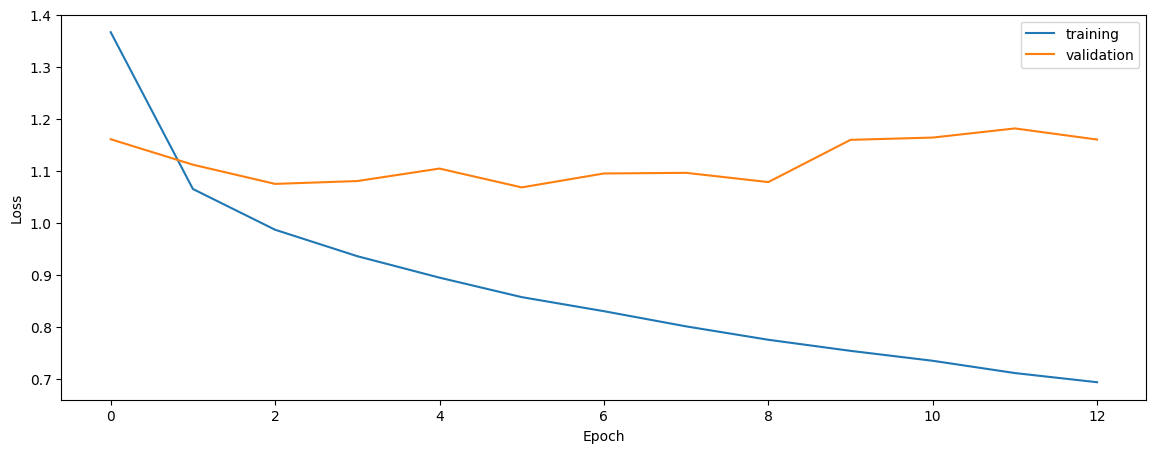

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['threshold'] = 0.6
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_1_0_0_1_1_t1t2_normalized_e_n_e_0_0_e_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1254584, 828)
(1254584, 1)
validation
(166224, 828)
(166224, 1)
test
(164640, 828)
(164640, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 828)]             0         


 dense_5 (Dense)             (None, 1024)              848896    


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

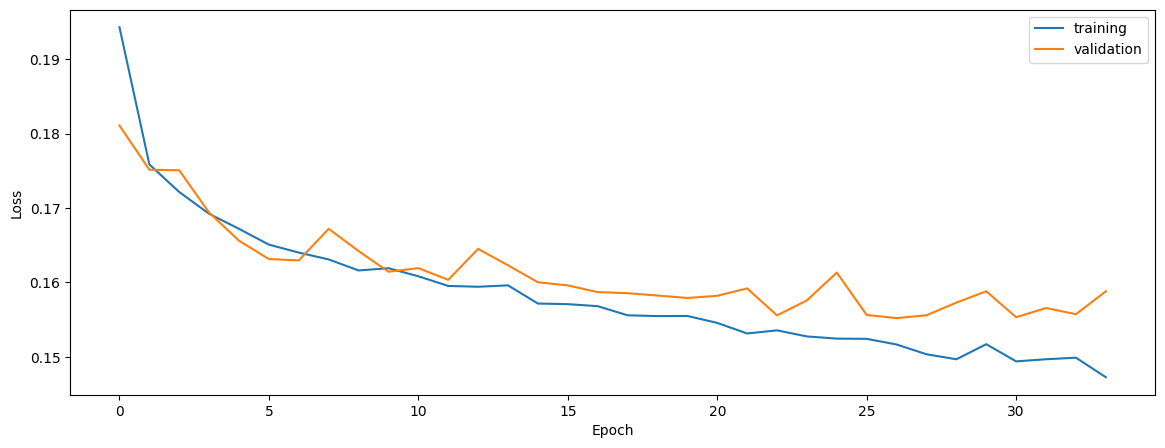

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['not_connected'] = True
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1t2','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    not_connected = np.where(reg < threshold, 1, 0)
    not_connected = np.expand_dims(not_connected,-1)
    pred = np.concatenate([pred,not_connected],-1)
    for i in range(cla.shape[-1]):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('normalized')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

normalized
0.6576718521817485
0.6244567793931732
0.625111236954939


In [16]:
print('native')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

native
0.6554617191661253
0.6300203114421123
0.6183696289981511


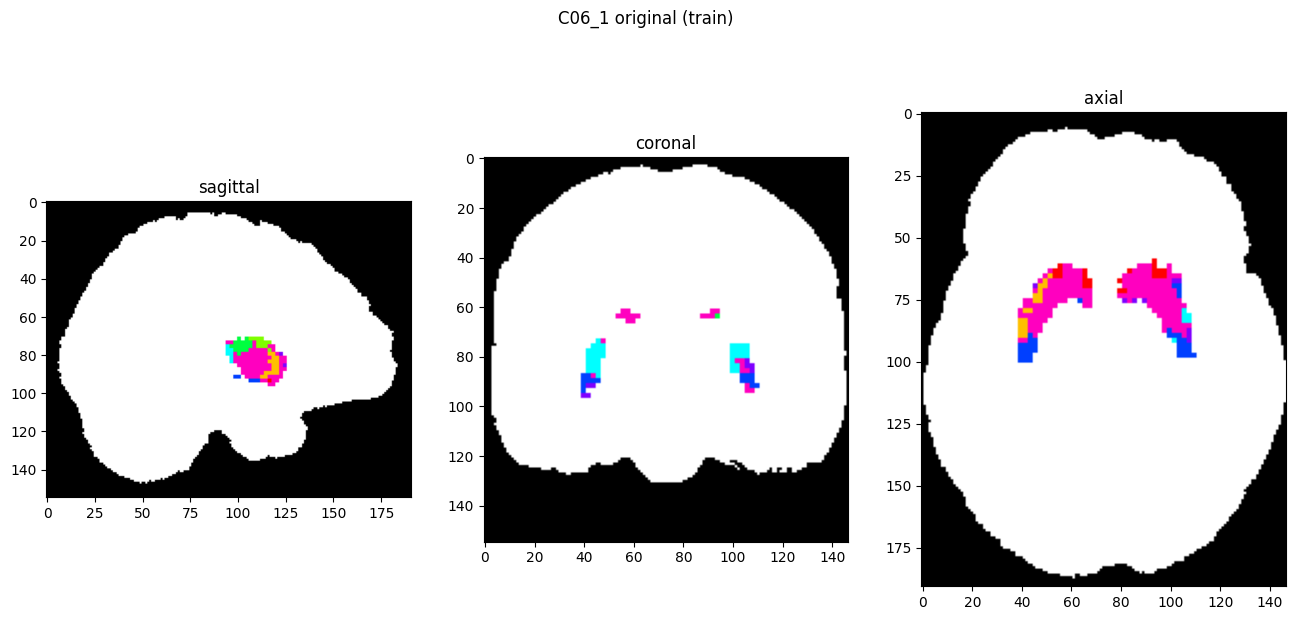

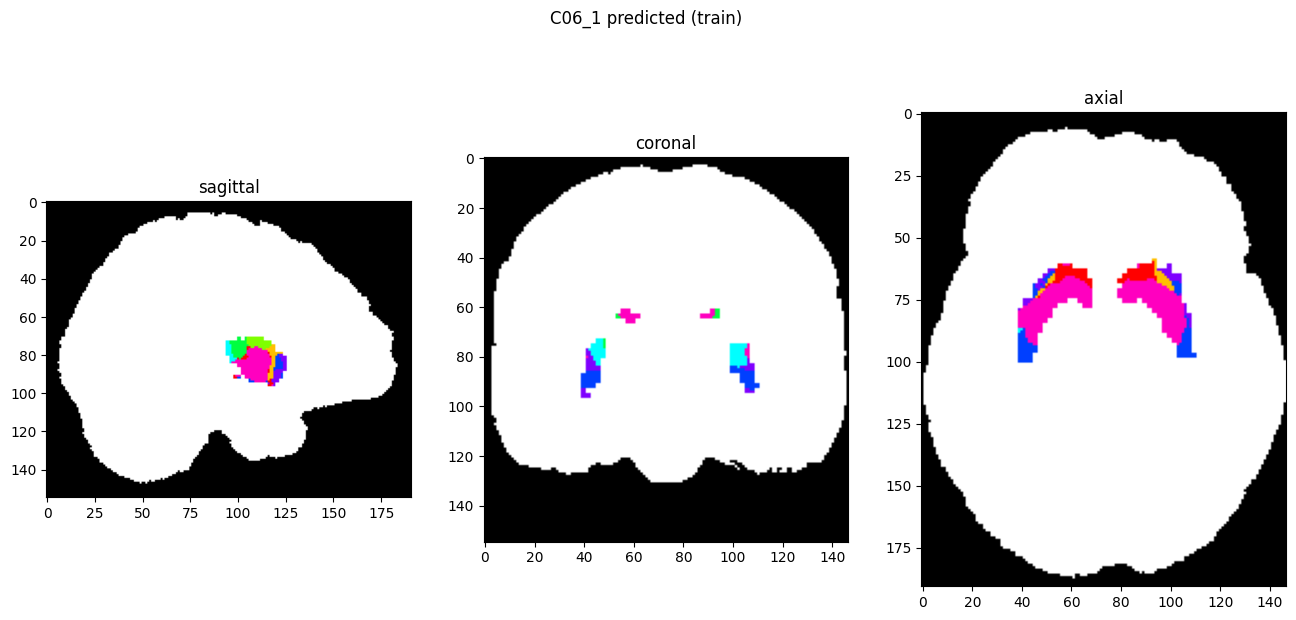

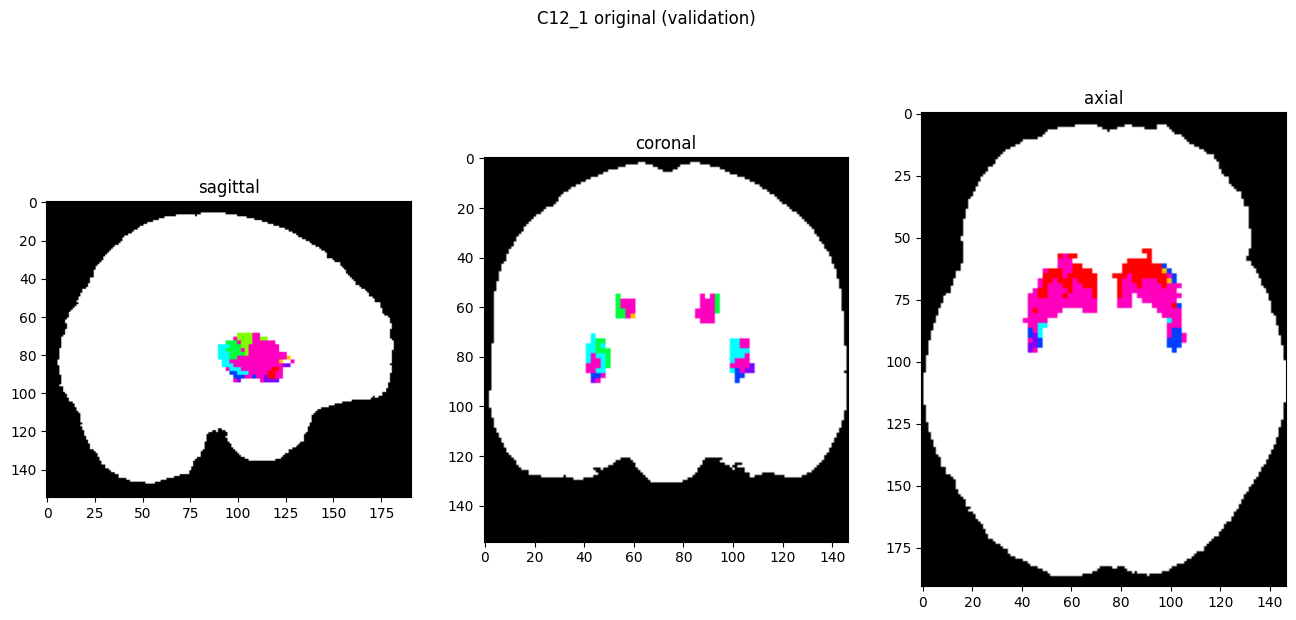

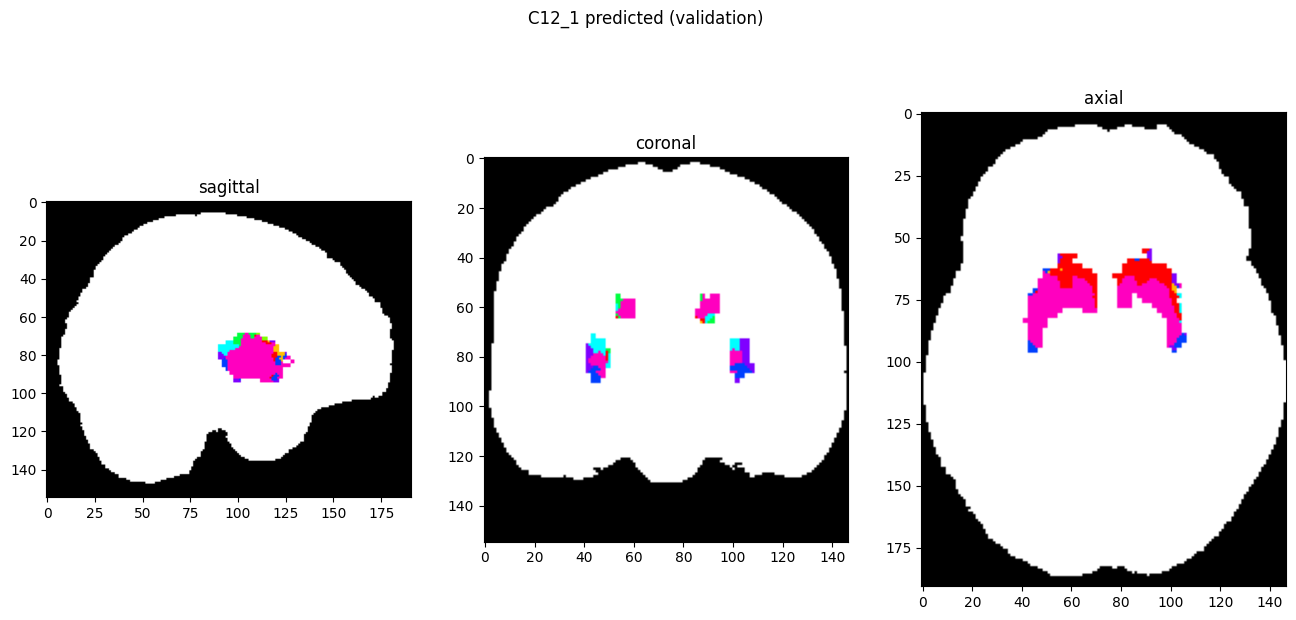

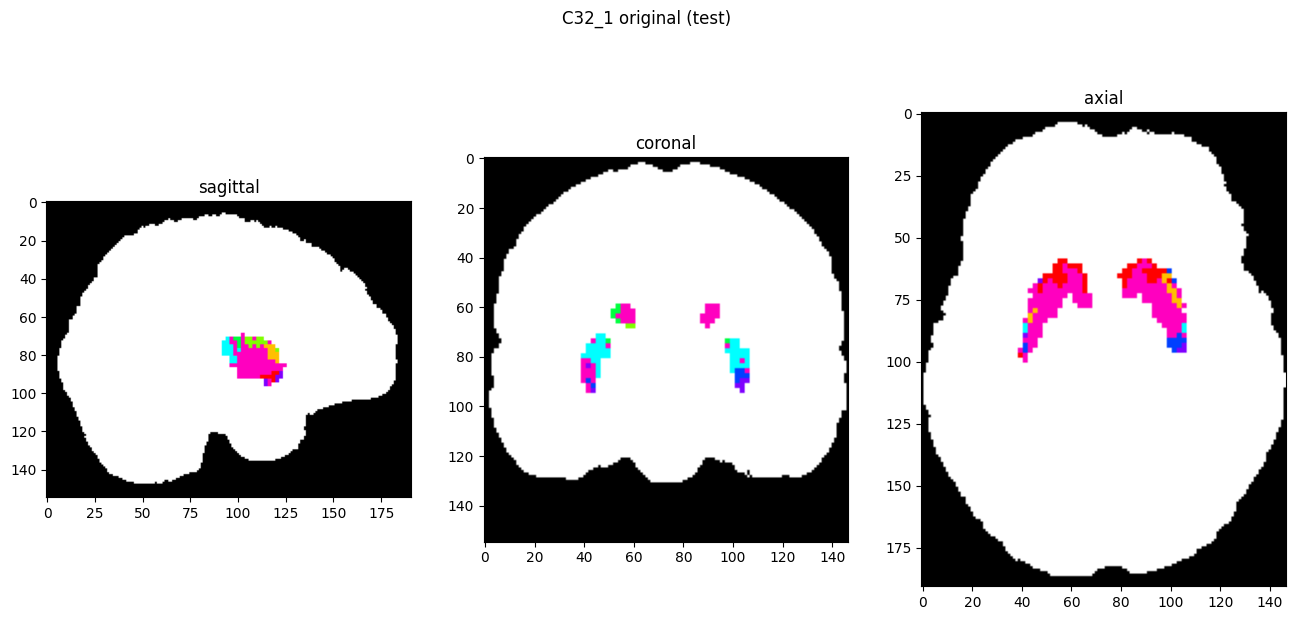

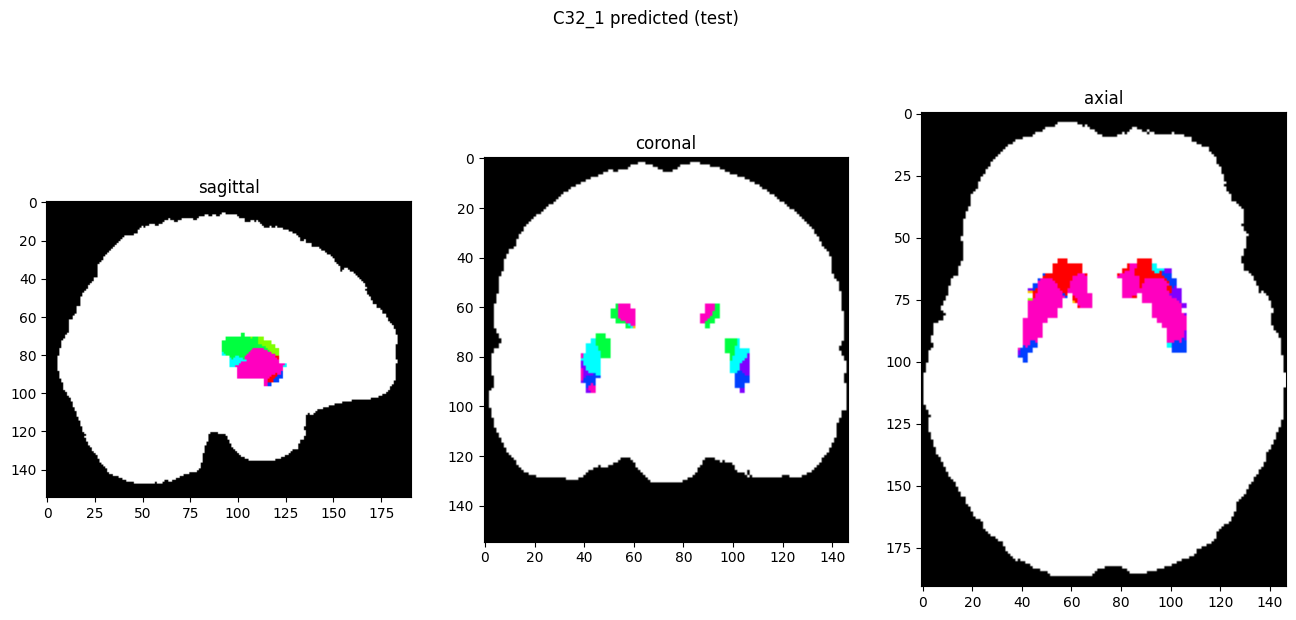

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)